**Author:** Rutendo F. Sigauke

# Load libraries

In [1]:
library(data.table)
library(dplyr)
library(ggplot2)
library(cowplot)
library(VennDiagram)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

Loading required package: futile.logger



# Import data

## SPEC scores

In [2]:
spec <- data.table::fread('/scratch/Shares/dowell/dbnascent/out/meta_analysis/specs_scores/filt_qc123_all_specs_all.txt')
dim(spec)
head(spec, 3)

[1] 872689     14

gene_transcript,blood,brain,breast,embryo,heart,intestine,kidney,liver,lung,prostate,skin,umbilical cord,uterus
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DDX11L1:NR_046018.2,0.000000,0.0000000,0.00612994,0.03597269,0.04447492,0.06131972,0.03030785,0.000000,0.0356784,0.0000000,0.03585838,0.0000000,0.3269084
WASH7P:NR_024540.1,0.682615,0.1971741,0.53927819,0.26995004,0.39759784,0.65313209,0.55084316,0.592334,0.4879931,0.3566531,0.63192179,0.5649252,0.5755542
MIR1302-2:NR_036051.1,0.000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0.01587302,0.000000,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000


In [3]:
spec_max <- data.table::fread('/scratch/Shares/dowell/dbnascent/out/meta_analysis/specs_scores/filt_qc123_all_specs_maxval.txt')
colnames(spec_max) <- c('gene_transcript', 'max_spec','tissue_max_spec')
head(spec_max, 3)

gene_transcript,max_spec,tissue_max_spec
<chr>,<dbl>,<chr>
KLK3:NM_001648.2,1,prostate
KLK4:NM_001302961.2,1,prostate
SI:NM_001041.4,1,prostate


In [4]:
spec_min <- data.table::fread('/scratch/Shares/dowell/dbnascent/out/meta_analysis/specs_scores/filt_qc123_all_specs_minval.txt')
colnames(spec_min) <- c('gene_transcript', 'min_spec','tissue_min_spec')
head(spec_min, 3)

gene_transcript,min_spec,tissue_min_spec
<chr>,<dbl>,<chr>
chr2:108493729-108494109,0.4309521,kidney
chr12:42444546-42444870,0.4303498,lung
chr3:69106625-69106841,0.4233548,liver


## Significant pairs

In [5]:
sig_pairs_path <- "/scratch/Shares/dowell/dbnascent/out/meta_analysis/gene_bidir_significant_pairs"

##get paths for the tables
corr_sig_files <- list.files(path=sig_pairs_path,
                         pattern="tsv.gz",
                         full.names=TRUE)

##load all correlation files 
corr_sig_DT_list <- lapply(corr_sig_files,
                       data.table::fread,
                       nThread = 10) 

In [6]:
#get list of files
sig_pairs_filenames <- list.files(path=sig_pairs_path,
                         pattern="tsv.gz",
                         full.names=FALSE)

#extract the tissue ids from file name
tissue_ids <- as.character(lapply(strsplit(sig_pairs_filenames, '_'),
                                                    `[`, 2)) 

#replace the dash with spaces
tissue_ids_space <- gsub("-", " ", tissue_ids)
tissue_ids_space

[1] "blood"          "breast"         "embryo"         "heart"         
 [5] "intestine"      "kidney"         "lung"           "prostate"      
 [9] "skin"           "umbilical cord" "uterus"

In [7]:
tissue_ids
names(corr_sig_DT_list) <- tissue_ids_space #tissue_ids 
tissue_ids_space

[1] "blood"          "breast"         "embryo"         "heart"         
 [5] "intestine"      "kidney"         "lung"           "prostate"      
 [9] "skin"           "umbilical-cord" "uterus"

[1] "blood"          "breast"         "embryo"         "heart"         
 [5] "intestine"      "kidney"         "lung"           "prostate"      
 [9] "skin"           "umbilical cord" "uterus"

In [8]:
# add a column with tissue names
corr_sig_DT_list <- mapply(`[<-`, 
                           corr_sig_DT_list, 
                           'tissue', 
                           value = tissue_ids_space, 
                           SIMPLIFY = FALSE)

In [9]:
# merge all the pair table
corr_sig_DT <- do.call(rbind, corr_sig_DT_list)

# add a pair id column
corr_sig_DT$pair_id <- paste0(corr_sig_DT$transcript_1,
                                "~",
                              corr_sig_DT$transcript_2)
nrow(corr_sig_DT)
head(corr_sig_DT)

[1] 8315182

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,adj_p_BH,nObs,t,distance_tss,distance_tes,position,percent_transcribed_both,bidirectional_location,tissue,pair_id
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,749695,750013,chr10:749695-750013,⋯,3.002834e-04,4,188.756638,-701308,-702967,upstream,1.801802,intergenic,blood,TUBB8:NM_177987.3~chr10:749695-750013
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,986401,986877,chr10:986401-986877,⋯,2.238290e-04,48,4.750869,-938093,-939752,upstream,21.621622,intergenic,blood,TUBB8:NM_177987.3~chr10:986401-986877
chr10,180743,249790,ZMYND11:NM_001202467.1,.,+,chr10,124900,125180,chr10:124900-125180,⋯,8.736896e-05,130,4.684712,-55703,-124750,upstream,58.558559,intergenic,blood,ZMYND11:NM_001202467.1~chr10:124900-125180
chr10,180743,249790,ZMYND11:NM_001202467.1,.,+,chr10,125590,125860,chr10:125590-125860,⋯,1.001372e-08,153,6.711378,-55018,-124065,upstream,68.918919,intergenic,blood,ZMYND11:NM_001202467.1~chr10:125590-125860
chr10,180743,249790,ZMYND11:NM_001202467.1,.,+,chr10,126570,127168,chr10:126570-127168,⋯,2.040315e-06,190,5.516402,-53874,-122921,upstream,85.585586,intergenic,blood,ZMYND11:NM_001202467.1~chr10:126570-127168
chr10,180743,249790,ZMYND11:NM_001202467.1,.,+,chr10,704805,705165,chr10:704805-705165,⋯,9.359145e-05,43,5.119993,524242,455195,downstream,19.369369,intergenic,blood,ZMYND11:NM_001202467.1~chr10:704805-705165


In [10]:
length(unique(corr_sig_DT$pair_id))

[1] 4853276

## Housekeeping genes

In [11]:
gtex_low_gc <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc_reviews/annotations/housekeeping_genes/journal.pcbi.1010295.s014.GTEx.tsv")
nrow(gtex_low_gc)
head(gtex_low_gc)

[1] 3688

Genes
<chr>
NDUFA2
AP3S2
POLR2J
NDUFB7
SDHC
MRPL27


## RefSeq

In [12]:
hg38_genes <- data.table::fread("/scratch/Shares/dowell/genomes/hg38/ncbi/hg38_refseq_diff53prime.bed")
hg38_genes$gene_transcripts <- as.character(lapply(strsplit(hg38_genes$V4, ','),
                                                    `[`, 1)) 
dim(hg38_genes)
head(hg38_genes)

[1] 42249     7

V1,V2,V3,V4,V5,V6,gene_transcripts
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
chr1,100038094,100083377,MFSD14A:NM_033055.3,.,+,MFSD14A:NM_033055.3
chr1,100083569,100132930,"SASS6:NM_194292.3,NM_001304829.2",.,-,SASS6:NM_194292.3
chr1,100133162,100150496,"TRMT13:NM_019083.3,NM_001393409.1,NM_001393410.1,NM_001393411.1,NM_001393412.1,NM_001393413.1,NM_001393414.1,NR_135078.2",.,+,TRMT13:NM_019083.3
chr1,100148447,100178256,"LRRC39:NM_144620.4,NM_001256385.2,NM_001256386.2,NM_001256387.2",.,-,LRRC39:NM_144620.4
chr1,100186918,100249834,"DBT:NM_001918.5,NM_001399969.1,NM_001399972.1,NR_174363.1,NR_174364.1,NR_174365.1,NR_174366.1",.,-,DBT:NM_001918.5
chr1,100264741,100266174,"RTCA-AS1:NR_110434.1,NR_110435.1",.,-,RTCA-AS1:NR_110434.1


## Bidirectional type

Definition of bidirectionals as *promoter*, *intergenic*, *intronic*... from Lynn.

In [13]:
gene_bidir_types <- data.table::fread("/scratch/Shares/dowell/dbnascent/out/meta_analysis/specs_scores/hg38_all_classification.txt",
                                header=FALSE)
colnames(gene_bidir_types) <- c("gene_transcript", "transcript_type") 
dim(gene_bidir_types)
head(gene_bidir_types, 3)
tail(gene_bidir_types, 3)

[1] 947558      2

gene_transcript,transcript_type
<chr>,<chr>
A1BG-AS1:NR_015380.2,noncoding
A1BG:NM_130786.4,coding
A1CF:NM_014576.4,coding


gene_transcript,transcript_type
<chr>,<chr>
chrY:56881721-56881941,intergenic
chrY:56883158-56883488,intergenic
chrY:56884695-56885095,intergenic


## GTEx pairs

In [14]:
gtex_overlaps_path <- "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_eqtl_nascent_pairs_matched/sig_pair_gtex_overlaps_matched_tissue.tsv.gz"
sig_pair_gtex_overlaps_matched_tissue <- data.table::fread(gtex_overlaps_path)
nrow(sig_pair_gtex_overlaps_matched_tissue)
head(sig_pair_gtex_overlaps_matched_tissue)

[1] 269106

transcript_2,transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,⋯,alt_variant,ref,chr_bidir,start_bidir,end_bidir,gtex_snp_id,variant_id,tissue_id_gtx_bidir,gene_name,promoter_enhancer
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
chr10:100005357-100005829,chr10,99875570,99913342,DNMBP:NM_001318327.1,.,-,chr10,100005357,100005829,⋯,C,b38,chr10,100005357,100005829,chr10:100005357-100005358,chr10_100005358_G_C_b38,breast,DNMBP,enhancer
chr10:100005357-100005829,chr10,99875570,99913342,DNMBP:NM_001318327.1,.,-,chr10,100005357,100005829,⋯,A,b38,chr10,100005357,100005829,chr10:100005710-100005711,chr10_100005711_G_A_b38,breast,DNMBP,enhancer
chr10:100005357-100005829,chr10,99875570,99913342,DNMBP:NM_001318327.1,.,-,chr10,100005357,100005829,⋯,C,b38,chr10,100005357,100005829,chr10:100005357-100005358,chr10_100005358_G_C_b38,heart,DNMBP,enhancer
chr10:100005357-100005829,chr10,99875570,99913342,DNMBP:NM_001318327.1,.,-,chr10,100005357,100005829,⋯,A,b38,chr10,100005357,100005829,chr10:100005710-100005711,chr10_100005711_G_A_b38,heart,DNMBP,enhancer
chr10:100005357-100005829,chr10,99875570,99913342,DNMBP:NM_001318327.1,.,-,chr10,100005357,100005829,⋯,C,b38,chr10,100005357,100005829,chr10:100005357-100005358,chr10_100005358_G_C_b38,heart,DNMBP,enhancer
chr10:100005357-100005829,chr10,99875570,99913342,DNMBP:NM_001318327.1,.,-,chr10,100005357,100005829,⋯,A,b38,chr10,100005357,100005829,chr10:100005710-100005711,chr10_100005711_G_A_b38,heart,DNMBP,enhancer


In [15]:
stringent_sig_pair_gtex_overlaps_matched_tissue <- subset(sig_pair_gtex_overlaps_matched_tissue,
                                                         adj_p_BH < 0.001)

## ChIA-PET loops  

In [16]:
overlap_looped_DT <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/3d_overlap/nascent_pairs_with_loop/hg38_dbnascent_pairs_with_all_chiapet_by_tissue.tsv.gz")
overlap_looped_DT$gene_transcript <- as.character(lapply(strsplit(overlap_looped_DT$pair_id, '~'),
                                                    `[`, 1))
overlap_looped_DT$bidir_id <- as.character(lapply(strsplit(overlap_looped_DT$pair_id, '~'),
                                                    `[`, 2))
dim(overlap_looped_DT)
head(overlap_looped_DT)


[1] 4345395       4

pair_id,tissue,gene_transcript,bidir_id
<chr>,<chr>,<chr>,<chr>
LARP4B-DT:NR_120629.1~chr10:969848-970172,blood,LARP4B-DT:NR_120629.1,chr10:969848-970172
GTPBP4:NM_012341.3~chr10:791474-791828,blood,GTPBP4:NM_012341.3,chr10:791474-791828
GTPBP4:NM_012341.3~chr10:974047-974607,blood,GTPBP4:NM_012341.3,chr10:974047-974607
WDR37:NM_014023.4~chr10:106635-107175,blood,WDR37:NM_014023.4,chr10:106635-107175
WDR37:NM_014023.4~chr10:974047-974607,blood,WDR37:NM_014023.4,chr10:974047-974607
TASOR2:NR_135800.2~chr10:4944618-4945310,blood,TASOR2:NR_135800.2,chr10:4944618-4945310


# SPEC Scores Summary

In [17]:
colnames(spec)

[1] "gene_transcript" "blood"           "brain"           "breast"         
 [5] "embryo"          "heart"           "intestine"       "kidney"         
 [9] "liver"           "lung"            "prostate"        "skin"           
[13] "umbilical cord"  "uterus"

In [18]:
unique(corr_sig_DT$tissue)

[1] "blood"          "breast"         "embryo"         "heart"         
 [5] "intestine"      "kidney"         "lung"           "prostate"      
 [9] "skin"           "umbilical cord" "uterus"

## All genes SPEC scores for tissues with pairs

In [19]:
#subset trancripts and columns with matching tissues from pairs
spec_tissue_overlap <- spec[,c("gene_transcript",
                               unique(corr_sig_DT$tissue)), 
                            with = FALSE]
spec_tissue_overlap$min <- apply(spec_tissue_overlap[,c(2:12)], 1, min)
spec_tissue_overlap$max <- apply(spec_tissue_overlap[,c(2:12)], 1, max)
spec_tissue_overlap$median <- apply(spec_tissue_overlap[,c(2:12)], 1, median)
spec_tissue_overlap$mean <- apply(spec_tissue_overlap[,c(2:12)], 1, mean)
head(spec_tissue_overlap)

gene_transcript,blood,breast,embryo,heart,intestine,kidney,lung,prostate,skin,umbilical cord,uterus,min,max,median,mean
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DDX11L1:NR_046018.2,0.00000000,0.00612994,0.03597269,0.04447492,0.06131972,0.03030785,0.0356784,0.0000000,0.03585838,0.0000000,0.3269084,0.0000000,0.32690840,0.0356784,0.052422756
WASH7P:NR_024540.1,0.68261504,0.53927819,0.26995004,0.39759784,0.65313209,0.55084316,0.4879931,0.3566531,0.63192179,0.5649252,0.5755542,0.2699500,0.68261504,0.5508432,0.519133065
MIR1302-2:NR_036051.1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.01587302,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.01587302,0.0000000,0.001443001
FAM138A:NR_026818.1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.0000000,0.03703704,0.0000000,0.0000000,0.0000000,0.03703704,0.0000000,0.003367003
OR4F5:NM_001005484.2,0.02247927,0.00000000,0.00000000,0.00000000,0.02111681,0.01586706,0.0000000,0.0000000,0.00000000,0.0000000,0.0687337,0.0000000,0.06873370,0.0000000,0.011654258
LOC729737:NR_039983.2,0.36638236,0.84113400,0.74136575,0.24114171,0.74388226,0.24878260,0.3580371,0.3470698,0.30063485,0.5045444,0.1440996,0.1440996,0.84113400,0.3580371,0.439734034


In [20]:
#get gene ids without the transcript ID
spec_tissue_overlap$gene_id <- as.character(lapply(strsplit(spec_tissue_overlap$gene_transcript, ':'),
                                                    `[`, 1)) 

#label genes and bidirectionals
spec_tissue_overlap$transcript_type <- ifelse(spec_tissue_overlap$gene_transcript %in% hg38_genes$gene_transcripts,
                                              "gene", "bidirectional")

#label housekeeping genes
spec_tissue_overlap$gene_type <- ifelse(spec_tissue_overlap$gene_id %in% gtex_low_gc$Genes,
                                              "housekeeping", "non-housekeeping")
head(spec_tissue_overlap, 2)

gene_transcript,blood,breast,embryo,heart,intestine,kidney,lung,prostate,skin,umbilical cord,uterus,min,max,median,mean,gene_id,transcript_type,gene_type
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
DDX11L1:NR_046018.2,0.000000,0.00612994,0.03597269,0.04447492,0.06131972,0.03030785,0.0356784,0.0000000,0.03585838,0.0000000,0.3269084,0.00000,0.3269084,0.0356784,0.05242276,DDX11L1,gene,non-housekeeping
WASH7P:NR_024540.1,0.682615,0.53927819,0.26995004,0.39759784,0.65313209,0.55084316,0.4879931,0.3566531,0.63192179,0.5649252,0.5755542,0.26995,0.6826150,0.5508432,0.51913306,WASH7P,gene,non-housekeeping


### Median plot all

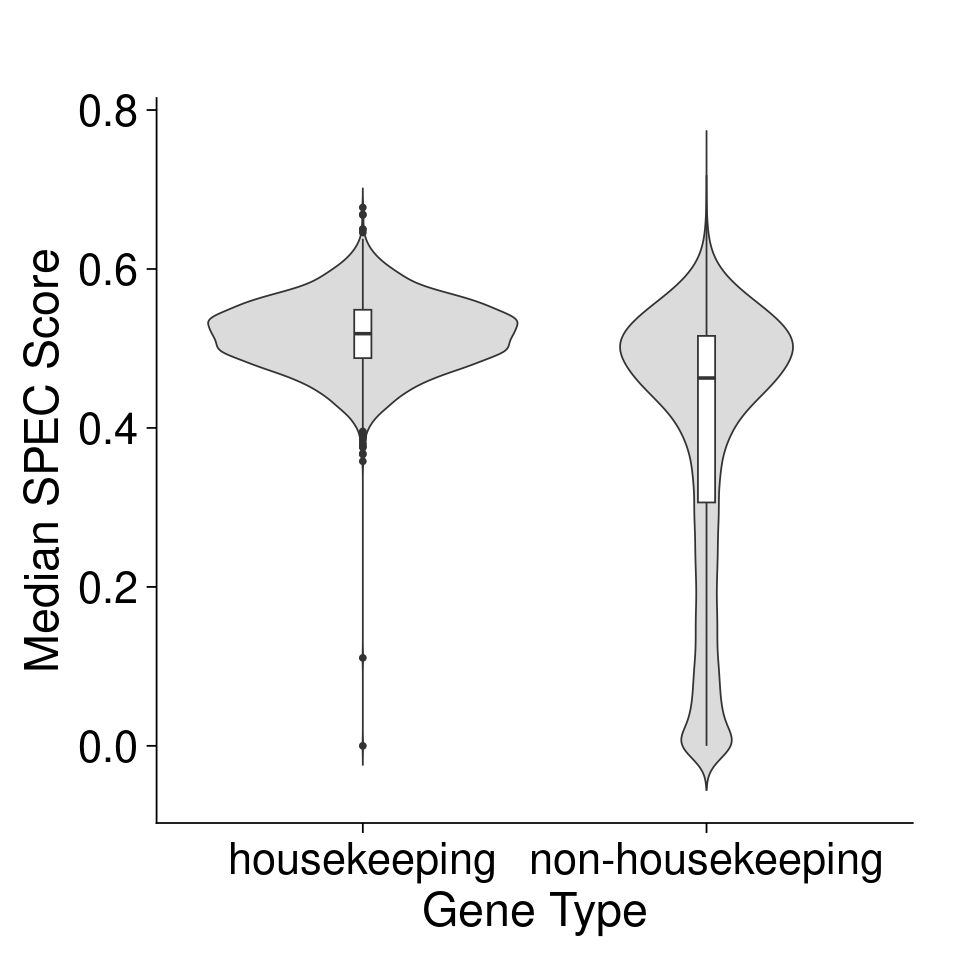

In [21]:
options(repr.plot.width=8, repr.plot.height=8)

# Use single color
spec_tissue_housekeeping_median_plot <- ggplot(subset(spec_tissue_overlap,
                                               transcript_type == "gene"), 
                                     aes(x=gene_type, y=median)) +
  geom_violin(trim=FALSE, color="gray20", fill="gray80", alpha=0.7)+
  geom_boxplot(width=0.05, fill="white") + 
labs(title = " ", 
       y = "Median SPEC Score",
       x = "Gene Type",
    fill=" ") +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 26)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

spec_tissue_housekeeping_median_plot

### Mean plot all

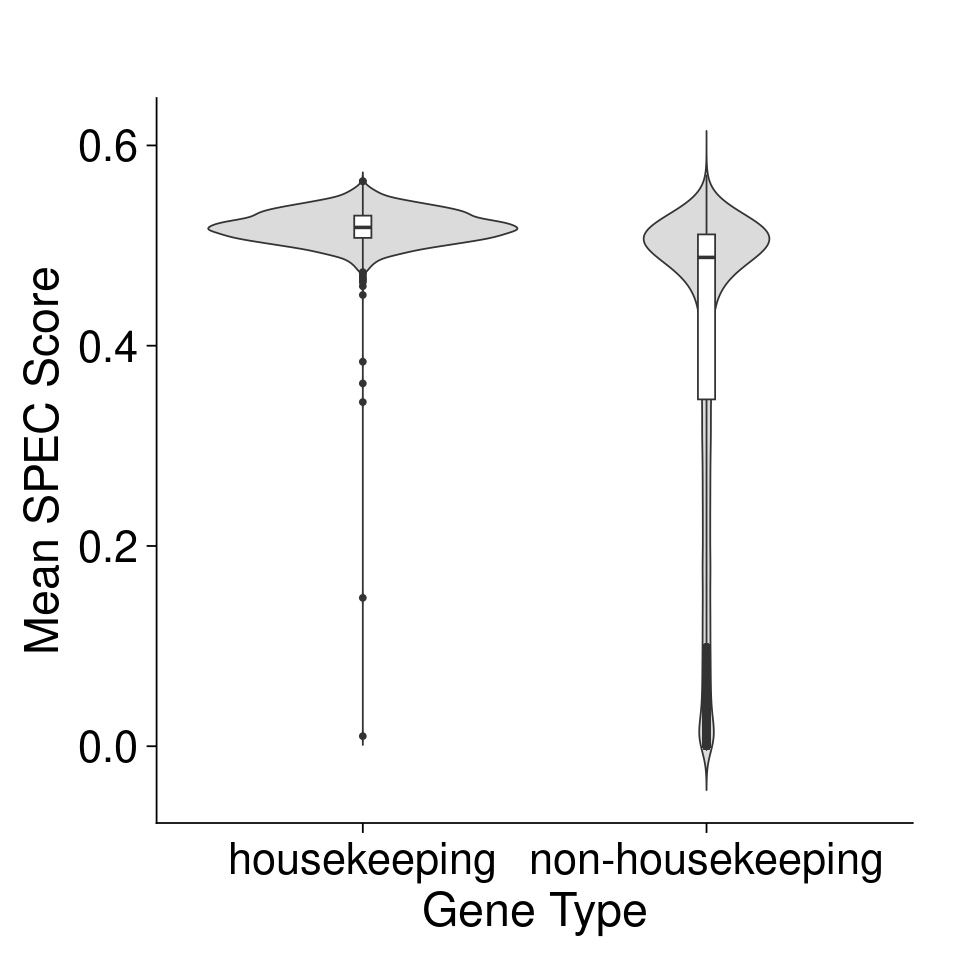

In [22]:
options(repr.plot.width=8, repr.plot.height=8)

# Use single color
spec_tissue_housekeeping_mean_plot <- ggplot(subset(spec_tissue_overlap,
                                               transcript_type == "gene"), 
                                     aes(x=gene_type, y=mean)) +
  geom_violin(trim=FALSE, color="gray20", fill="gray80", alpha=0.7)+
  geom_boxplot(width=0.05, fill="white") + 
labs(title = " ", 
       y = "Mean SPEC Score",
       x = "Gene Type",
    fill=" ") +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 26)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

spec_tissue_housekeeping_mean_plot

### Minimum plot all

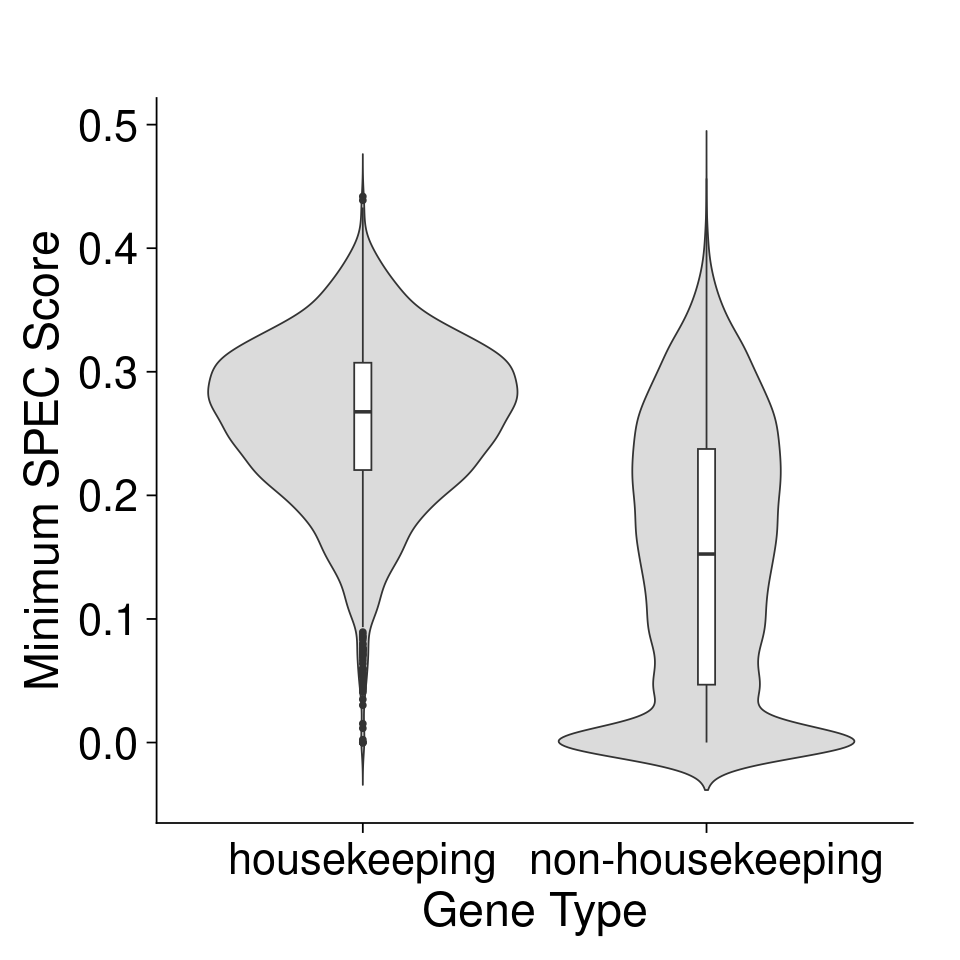

In [23]:
options(repr.plot.width=8, repr.plot.height=8)

# Use single color
spec_tissue_housekeeping_min_plot <- ggplot(subset(spec_tissue_overlap,
                                               transcript_type == "gene"), 
                                     aes(x=gene_type, y=min)) +
  geom_violin(trim=FALSE, color="gray20", fill="gray80", alpha=0.7)+
  geom_boxplot(width=0.05, fill="white") + 
labs(title = " ", 
       y = "Minimum SPEC Score",
       x = "Gene Type",
    fill=" ") +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 26)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

spec_tissue_housekeeping_min_plot

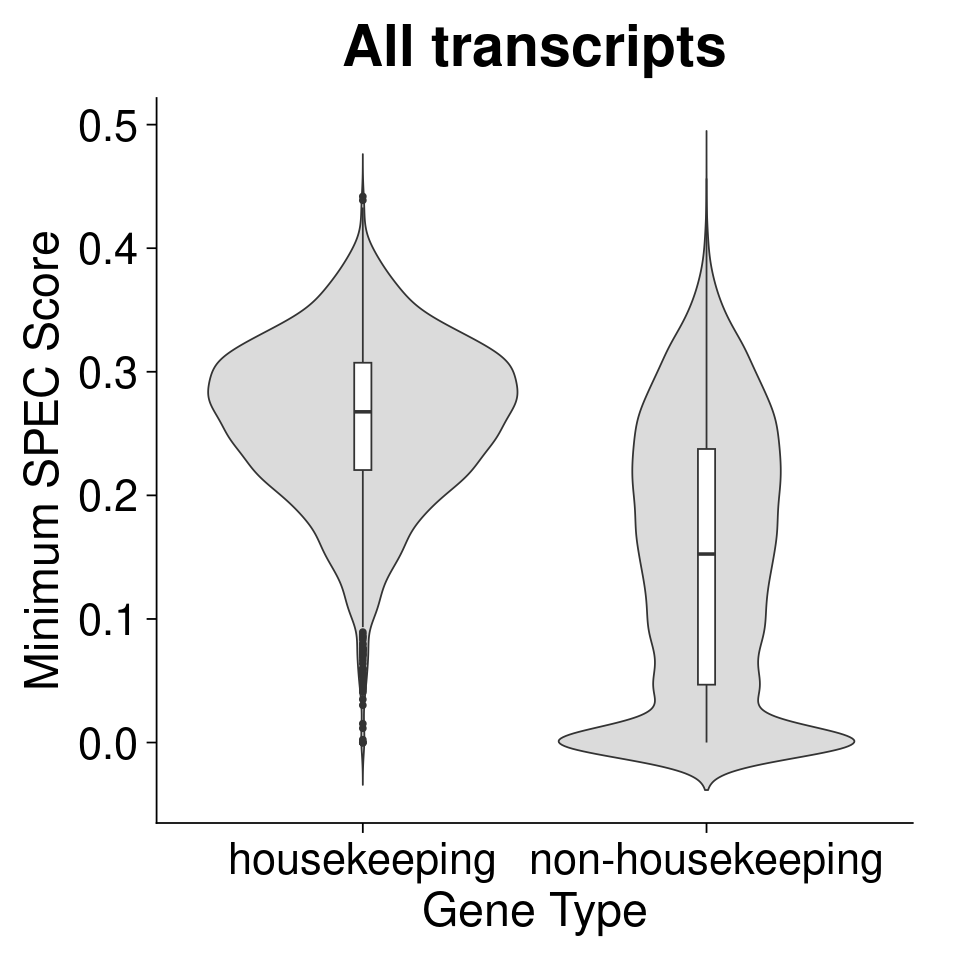

In [24]:
options(repr.plot.width=8, repr.plot.height=8)

# Use single color
spec_tissue_housekeeping_min_plotB <- ggplot(subset(spec_tissue_overlap,
                                               transcript_type == "gene"), 
                                     aes(x=gene_type, y=min)) +
  geom_violin(trim=FALSE, color="gray20", fill="gray80", alpha=0.7)+
  geom_boxplot(width=0.05, fill="white") + 
labs(title = "All transcripts", 
       y = "Minimum SPEC Score",
       x = "Gene Type",
    fill=" ") +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 26)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

spec_tissue_housekeeping_min_plotB

### Maximum plot all

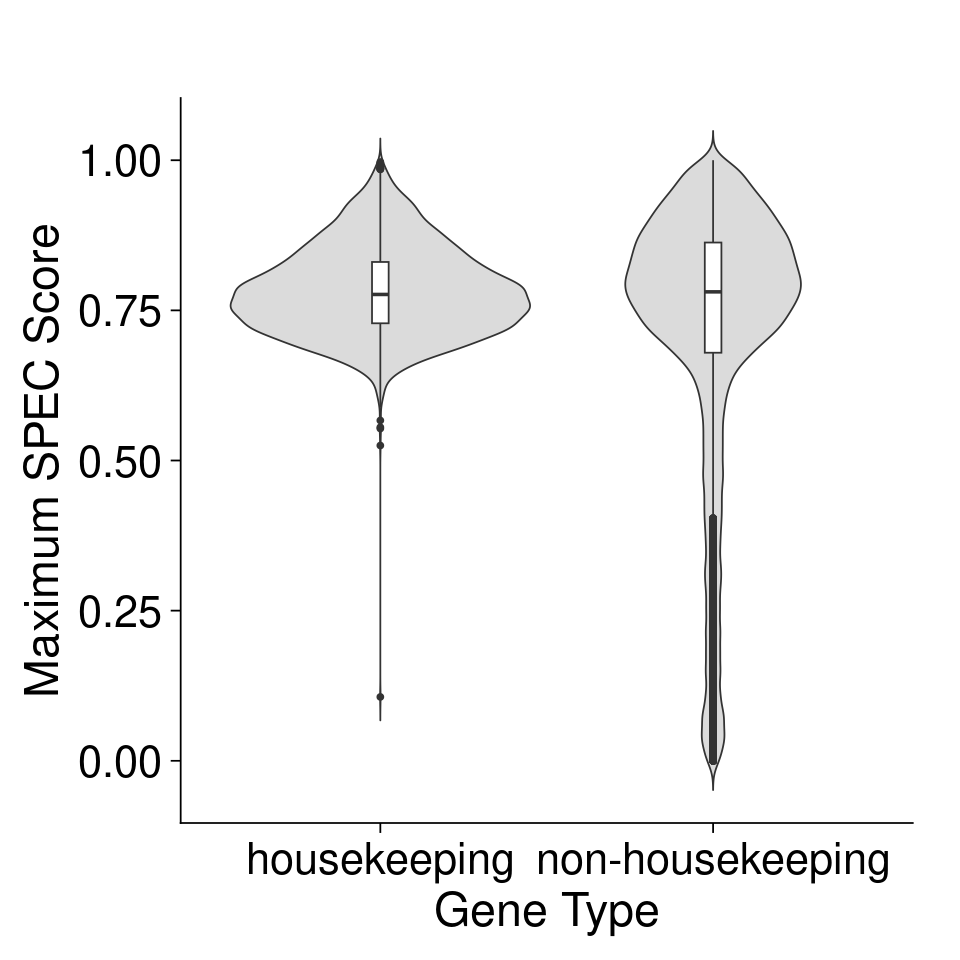

In [25]:
options(repr.plot.width=8, repr.plot.height=8)

# Use single color
spec_tissue_housekeeping_max_plot <- ggplot(subset(spec_tissue_overlap,
                                               transcript_type == "gene"), 
                                     aes(x=gene_type, y=max)) +
  geom_violin(trim=FALSE, color="gray20", fill="gray80", alpha=0.7)+
  geom_boxplot(width=0.05, fill="white") + 
labs(title = " ", 
       y = "Maximum SPEC Score",
       x = "Gene Type",
    fill=" ") +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 26)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

spec_tissue_housekeeping_max_plot

### Combine plots

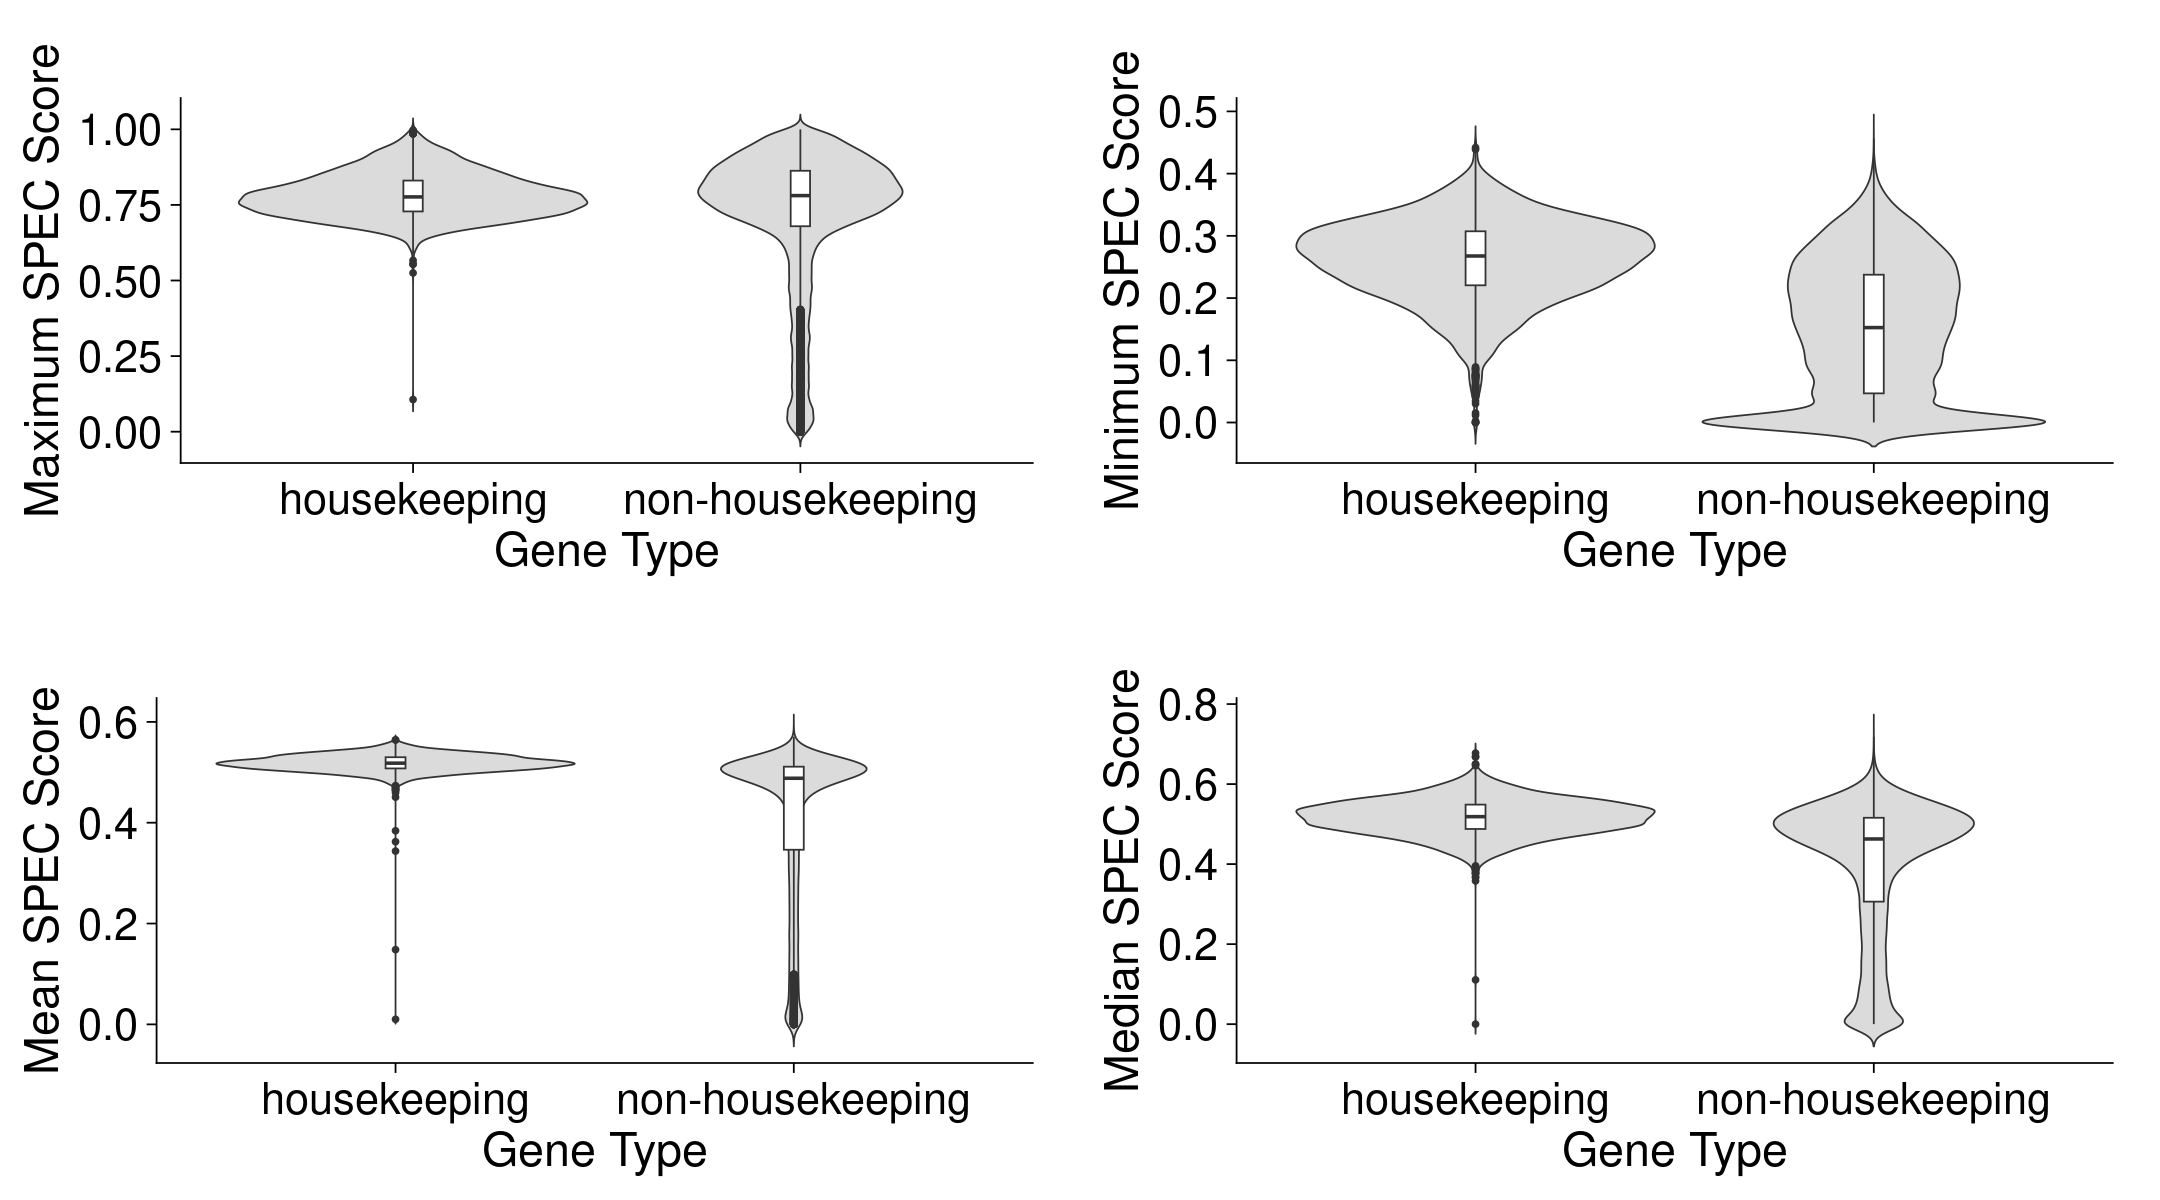

In [26]:
options(repr.plot.width=18, repr.plot.height=10)

cowplot::plot_grid(spec_tissue_housekeeping_max_plot,
                   spec_tissue_housekeeping_min_plot, 
                   spec_tissue_housekeeping_mean_plot,
                   spec_tissue_housekeeping_median_plot,
                   nrow=2)

## Sampled N to be even to housekeeping N

### Median even samples

In [27]:
spec_tissue_overlap_nonhouse <- subset(spec_tissue_overlap, 
                                       gene_type=="non-housekeeping" & 
                                       transcript_type =="gene")
dim(spec_tissue_overlap_nonhouse)
head(spec_tissue_overlap_nonhouse)

[1] 25198    19

gene_transcript,blood,breast,embryo,heart,intestine,kidney,lung,prostate,skin,umbilical cord,uterus,min,max,median,mean,gene_id,transcript_type,gene_type
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
DDX11L1:NR_046018.2,0.00000000,0.00612994,0.03597269,0.04447492,0.06131972,0.03030785,0.0356784,0.0000000,0.03585838,0.0000000,0.3269084,0.0000000,0.32690840,0.0356784,0.052422756,DDX11L1,gene,non-housekeeping
WASH7P:NR_024540.1,0.68261504,0.53927819,0.26995004,0.39759784,0.65313209,0.55084316,0.4879931,0.3566531,0.63192179,0.5649252,0.5755542,0.2699500,0.68261504,0.5508432,0.519133065,WASH7P,gene,non-housekeeping
MIR1302-2:NR_036051.1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.01587302,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000,0.01587302,0.0000000,0.001443001,MIR1302-2,gene,non-housekeeping
FAM138A:NR_026818.1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.0000000,0.03703704,0.0000000,0.0000000,0.0000000,0.03703704,0.0000000,0.003367003,FAM138A,gene,non-housekeeping
OR4F5:NM_001005484.2,0.02247927,0.00000000,0.00000000,0.00000000,0.02111681,0.01586706,0.0000000,0.0000000,0.00000000,0.0000000,0.0687337,0.0000000,0.06873370,0.0000000,0.011654258,OR4F5,gene,non-housekeeping
LOC729737:NR_039983.2,0.36638236,0.84113400,0.74136575,0.24114171,0.74388226,0.24878260,0.3580371,0.3470698,0.30063485,0.5045444,0.1440996,0.1440996,0.84113400,0.3580371,0.439734034,LOC729737,gene,non-housekeeping


In [28]:
#set a seed
set.seed(10)

#sample rows
spec_tissue_overlap_house <- subset(spec_tissue_overlap, 
                                       gene_type=="housekeeping" & 
                                       transcript_type =="gene")
spec_tissue_overlap_nonhouse_sample <- spec_tissue_overlap_nonhouse[sample(.N, nrow(spec_tissue_overlap_house))]
nrow(spec_tissue_overlap_nonhouse_sample)

[1] 3481

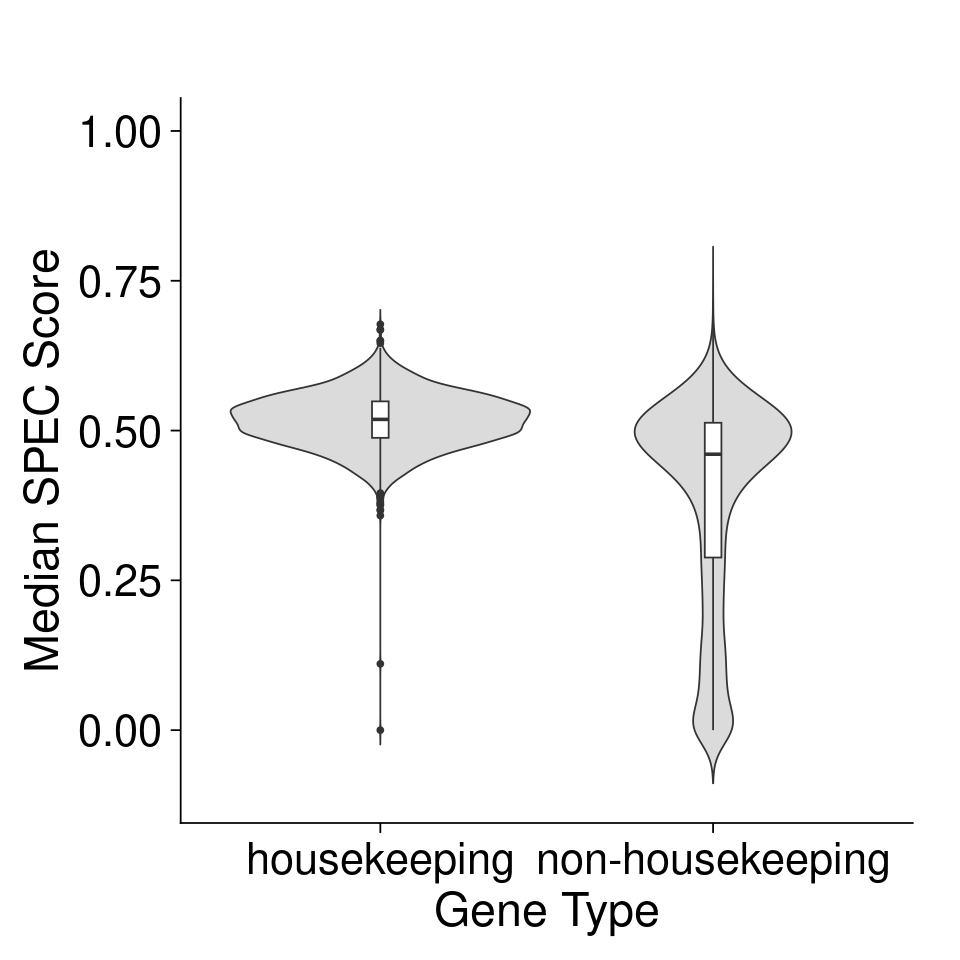

In [29]:
options(repr.plot.width=8, repr.plot.height=8)

# Use single color
spec_tissue_housekeeping_median_even_plot <- ggplot(rbind(spec_tissue_overlap_house, 
                                                    spec_tissue_overlap_nonhouse_sample), 
                                     aes(x=gene_type, y=median)) +
  geom_violin(trim=FALSE, color="gray20", fill="gray80", alpha=0.7)+
  geom_boxplot(width=0.05, fill="white") + 
labs(title = " ", 
       y = "Median SPEC Score",
       x = "Gene Type",
    fill=" ") +
scale_y_continuous(limits=c(-0.1, 1)) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 26)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

spec_tissue_housekeeping_median_even_plot

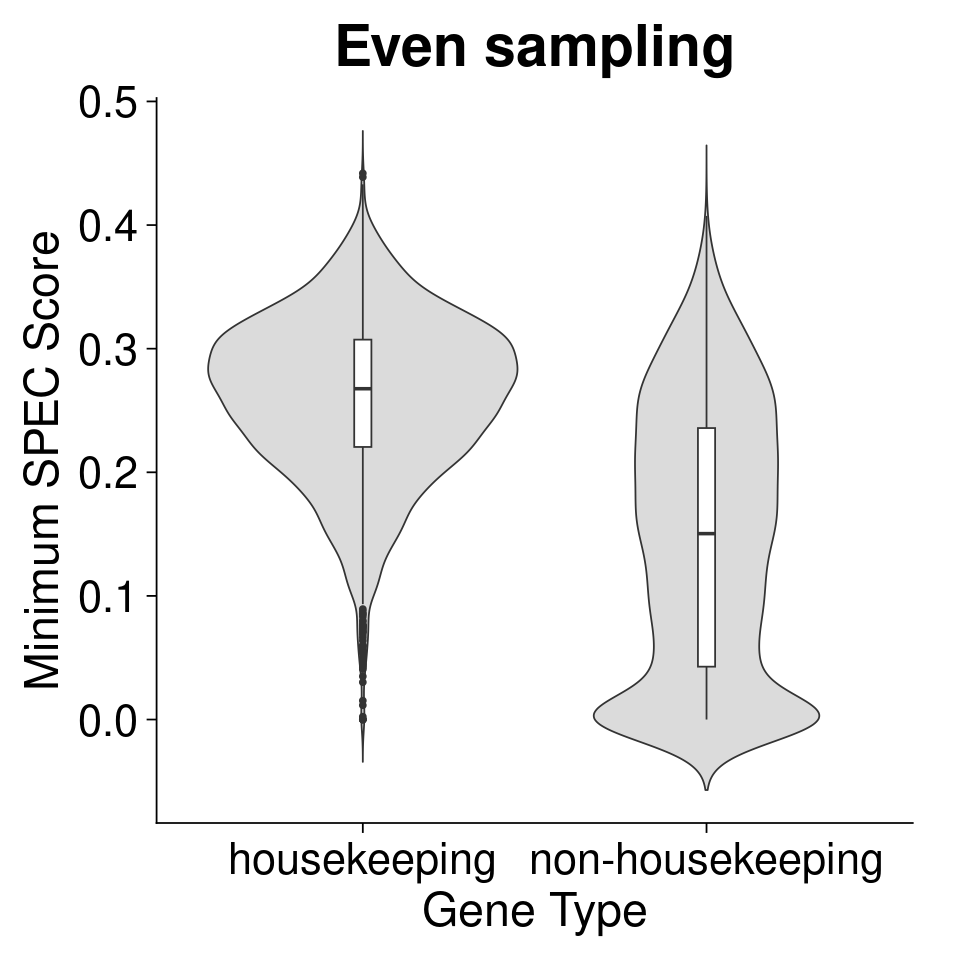

In [30]:
options(repr.plot.width=8, repr.plot.height=8)

# Use single color
spec_tissue_housekeeping_median_even_plotB <- ggplot(rbind(spec_tissue_overlap_house, 
                                                    spec_tissue_overlap_nonhouse_sample), 
                                     aes(x=gene_type, y=min)) +
  geom_violin(trim=FALSE, color="gray20", fill="gray80", alpha=0.7)+
  geom_boxplot(width=0.05, fill="white") + 
labs(title = "Even sampling", 
       y = "Minimum SPEC Score",
       x = "Gene Type",
    fill=" ") +
#scale_y_continuous(limits=c(-0.1, 1)) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 26)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

spec_tissue_housekeeping_median_even_plotB

# Tissue specificity of pairs vs SPECs

## Count pair across tissues

In [51]:
#1: get pairs with ChIA-PET support
corr_sig_DT_loop <- corr_sig_DT[corr_sig_DT$pair_id %in% overlap_looped_DT$pair_id,]
nrow(corr_sig_DT_loop)
length(unique(corr_sig_DT_loop$pair_id))

[1] 5771214

[1] 2705601

In [52]:
#2: count the number of pairs by/per tissue
no_tissues_for_pair <- as.data.frame(table(corr_sig_DT_loop$pair_id))
nrow(no_tissues_for_pair)
head(no_tissues_for_pair, 3)

[1] 2705601

,Var1,Freq
,<fct>,<int>
1,A1BG-AS1:NR_015380.2~chr19:57363902-57364246,1
2,A1BG-AS1:NR_015380.2~chr19:57429748-57430210,2
3,A1BG-AS1:NR_015380.2~chr19:57442340-57442746,1


In [53]:
no_tissues_for_pair$gene_id <- as.character(lapply(strsplit(as.character(no_tissues_for_pair$Var1), '~'),
                                                      `[`, 1))
no_tissues_for_pair$bidir_id <- as.character(lapply(strsplit(as.character(no_tissues_for_pair$Var1), '~'),
                                                      `[`, 2))
head(no_tissues_for_pair, 3)

,Var1,Freq,gene_id,bidir_id
,<fct>,<int>,<chr>,<chr>
1,A1BG-AS1:NR_015380.2~chr19:57363902-57364246,1,A1BG-AS1:NR_015380.2,chr19:57363902-57364246
2,A1BG-AS1:NR_015380.2~chr19:57429748-57430210,2,A1BG-AS1:NR_015380.2,chr19:57429748-57430210
3,A1BG-AS1:NR_015380.2~chr19:57442340-57442746,1,A1BG-AS1:NR_015380.2,chr19:57442340-57442746


In [54]:
no_tissues_for_pair_txptype <- merge(no_tissues_for_pair, 
                                    gene_bidir_types,
                                    by.x="bidir_id",
                                    by.y="gene_transcript")
dim(no_tissues_for_pair_txptype)
head(no_tissues_for_pair_txptype)

[1] 2843202       5

,bidir_id,Var1,Freq,gene_id,transcript_type
,<chr>,<fct>,<int>,<chr>,<chr>
1,chr1:1000004-1000574,INTS11:NM_017871.6~chr1:1000004-1000574,3,INTS11:NM_017871.6,promoter
2,chr1:1000004-1000574,NOC2L:NM_015658.4~chr1:1000004-1000574,2,NOC2L:NM_015658.4,promoter
3,chr1:1000004-1000574,FAM87B:NR_103536.1~chr1:1000004-1000574,1,FAM87B:NR_103536.1,promoter
4,chr1:1000004-1000574,UBE2J2:NM_058167.3~chr1:1000004-1000574,2,UBE2J2:NM_058167.3,promoter
5,chr1:1000004-1000574,MRPL20:NM_017971.4~chr1:1000004-1000574,3,MRPL20:NM_017971.4,promoter
6,chr1:1000004-1000574,TNFRSF4:NM_003327.4~chr1:1000004-1000574,2,TNFRSF4:NM_003327.4,promoter


In [55]:
no_tissues_for_pair_genetype <- merge(no_tissues_for_pair_txptype,
                                     spec_tissue_overlap[,c("gene_transcript",
                                                            "min","max","mean",
                                                            "median","gene_type")],
                                     by.x="gene_id",
                                     by.y="gene_transcript")

dim(no_tissues_for_pair_genetype)
head(no_tissues_for_pair_genetype)

[1] 2843202      10

,gene_id,bidir_id,Var1,Freq,transcript_type,min,max,mean,median,gene_type
,<chr>,<chr>,<fct>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,A1BG-AS1:NR_015380.2,chr19:58375763-58376039,A1BG-AS1:NR_015380.2~chr19:58375763-58376039,3,intronic,0.1091798,0.7858062,0.5394771,0.6426245,non-housekeeping
2,A1BG-AS1:NR_015380.2,chr19:57864280-57864758,A1BG-AS1:NR_015380.2~chr19:57864280-57864758,1,exonic,0.1091798,0.7858062,0.5394771,0.6426245,non-housekeeping
3,A1BG-AS1:NR_015380.2,chr19:57876845-57877303,A1BG-AS1:NR_015380.2~chr19:57876845-57877303,3,intronic,0.1091798,0.7858062,0.5394771,0.6426245,non-housekeeping
4,A1BG-AS1:NR_015380.2,chr19:58425680-58426120,A1BG-AS1:NR_015380.2~chr19:58425680-58426120,4,intronic,0.1091798,0.7858062,0.5394771,0.6426245,non-housekeeping
5,A1BG-AS1:NR_015380.2,chr19:58232407-58232773,A1BG-AS1:NR_015380.2~chr19:58232407-58232773,2,intronic,0.1091798,0.7858062,0.5394771,0.6426245,non-housekeeping
6,A1BG-AS1:NR_015380.2,chr19:58337184-58337626,A1BG-AS1:NR_015380.2~chr19:58337184-58337626,3,intronic,0.1091798,0.7858062,0.5394771,0.6426245,non-housekeeping


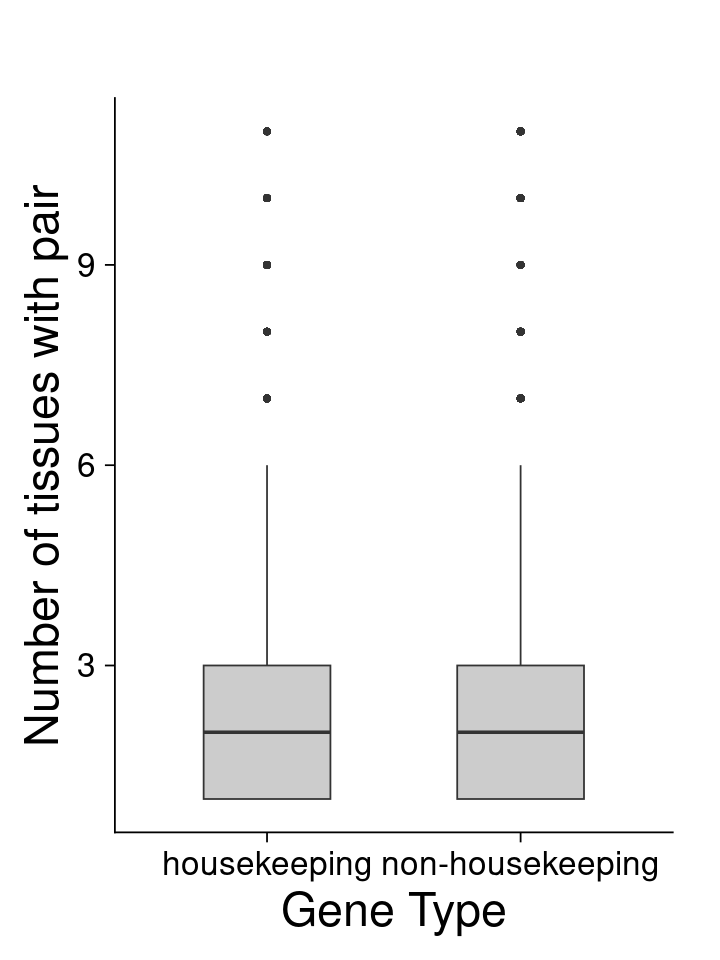

In [56]:
options(repr.plot.width=6, repr.plot.height=8)

# Use single color
housekeeping_num_tissues <- ggplot(no_tissues_for_pair_genetype, 
                                     aes(x=gene_type, y=Freq)) +
  #geom_violin(trim=FALSE, color="gray20", fill="gray80", alpha=0.7)+
  geom_boxplot(width=0.5, fill="gray80", color="gray20") + 
labs(title = " ", 
       y = "Number of tissues with pair",
       x = "Gene Type",
    fill=" ") +
#scale_y_continuous(limits=c(-0.1, 1)) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 20),
      axis.text.x = element_text(size = 20)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

housekeeping_num_tissues

In [57]:
median(subset(no_tissues_for_pair_genetype, gene_type=="housekeeping")$Freq)
median(subset(no_tissues_for_pair_genetype, gene_type!="housekeeping")$Freq)

[1] 2

[1] 2

In [58]:
mean(subset(no_tissues_for_pair_genetype, gene_type=="housekeeping")$Freq)
mean(subset(no_tissues_for_pair_genetype, gene_type!="housekeeping")$Freq)

[1] 2.443768

[1] 2.046187

In [59]:
max(subset(no_tissues_for_pair_genetype, gene_type=="housekeeping")$Freq)
max(subset(no_tissues_for_pair_genetype, gene_type!="housekeeping")$Freq)

[1] 11

[1] 11

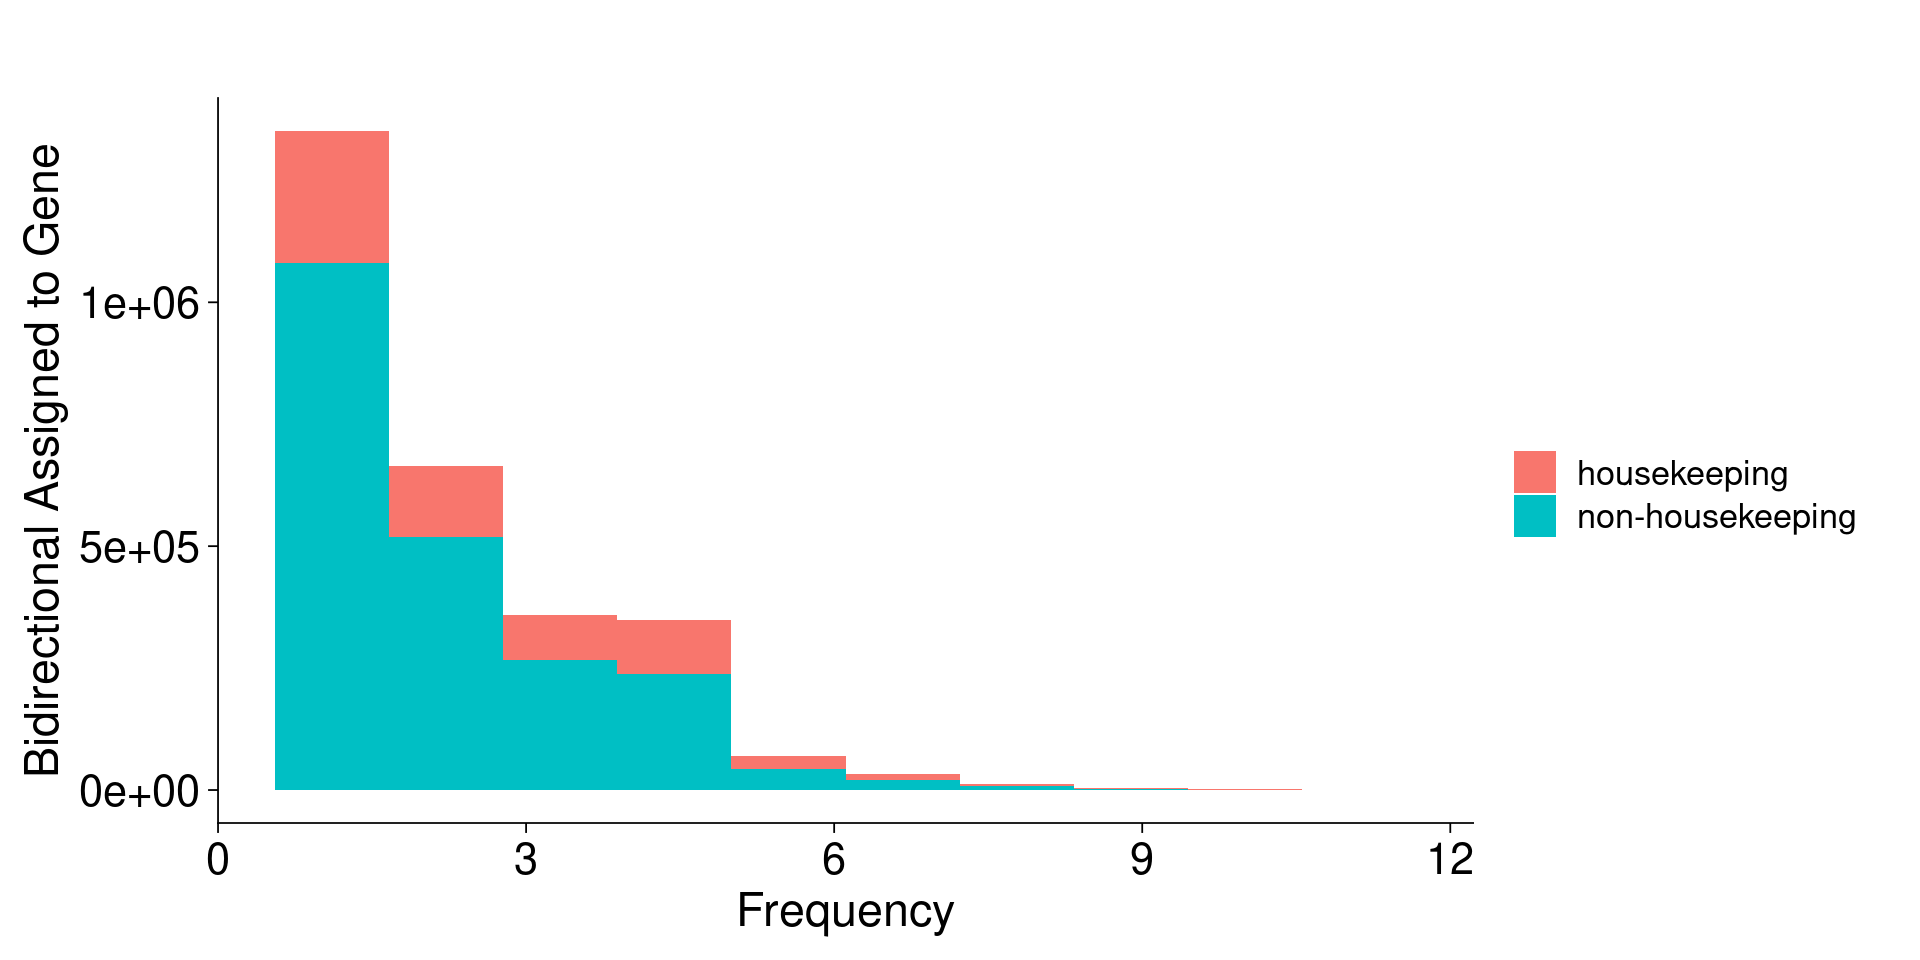

In [60]:
options(repr.plot.width=16, repr.plot.height=8)

housekeeping_num_bidir <- ggplot(no_tissues_for_pair_genetype, 
                                 aes(x=Freq, 
                                     group=gene_type, 
                                     fill=gene_type)) +
geom_histogram(bins = 10) + 
labs(title = " ", 
     y = "Bidirectional Assigned to Gene",
     x = "Frequency",
     fill= " ") +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 26),
      axis.text.x = element_text(size = 26)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

housekeeping_num_bidir

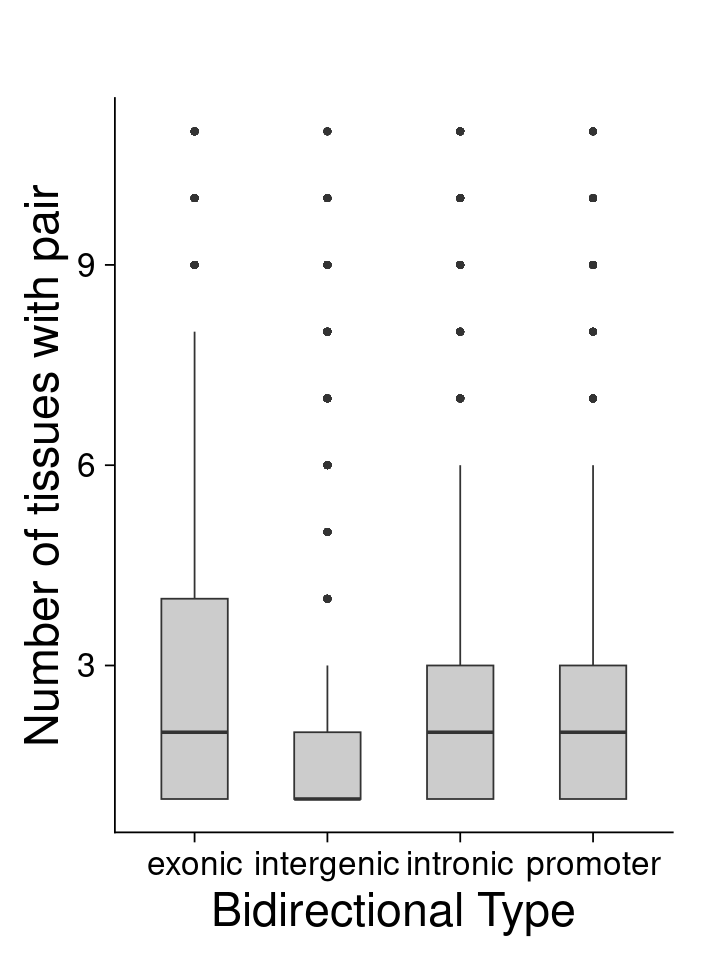

In [61]:
options(repr.plot.width=6, repr.plot.height=8)

# Use single color
bidirtype_num_tissues <- ggplot(no_tissues_for_pair_genetype, 
                                     aes(x=transcript_type, y=Freq)) +
  #geom_violin(trim=FALSE, color="gray20", fill="gray80", alpha=0.7)+
  geom_boxplot(width=0.5, fill="gray80", color="gray20") + 
labs(title = " ", 
       y = "Number of tissues with pair",
       x = "Bidirectional Type",
    fill=" ") +
#scale_y_continuous(limits=c(-0.1, 1)) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 20),
      axis.text.x = element_text(size = 20)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

bidirtype_num_tissues

In [62]:
gene_bidir_type_summary <- as.data.frame(table(no_tissues_for_pair_genetype[,
                                                                            c("gene_type","transcript_type")]))

gene_bidir_type_summary

gene_type,transcript_type,Freq
<fct>,<fct>,<int>
housekeeping,exonic,83804
non-housekeeping,exonic,266980
housekeeping,intergenic,188460
non-housekeeping,intergenic,645730
housekeeping,intronic,325066
non-housekeeping,intronic,1043910
housekeeping,promoter,65079
non-housekeeping,promoter,224173


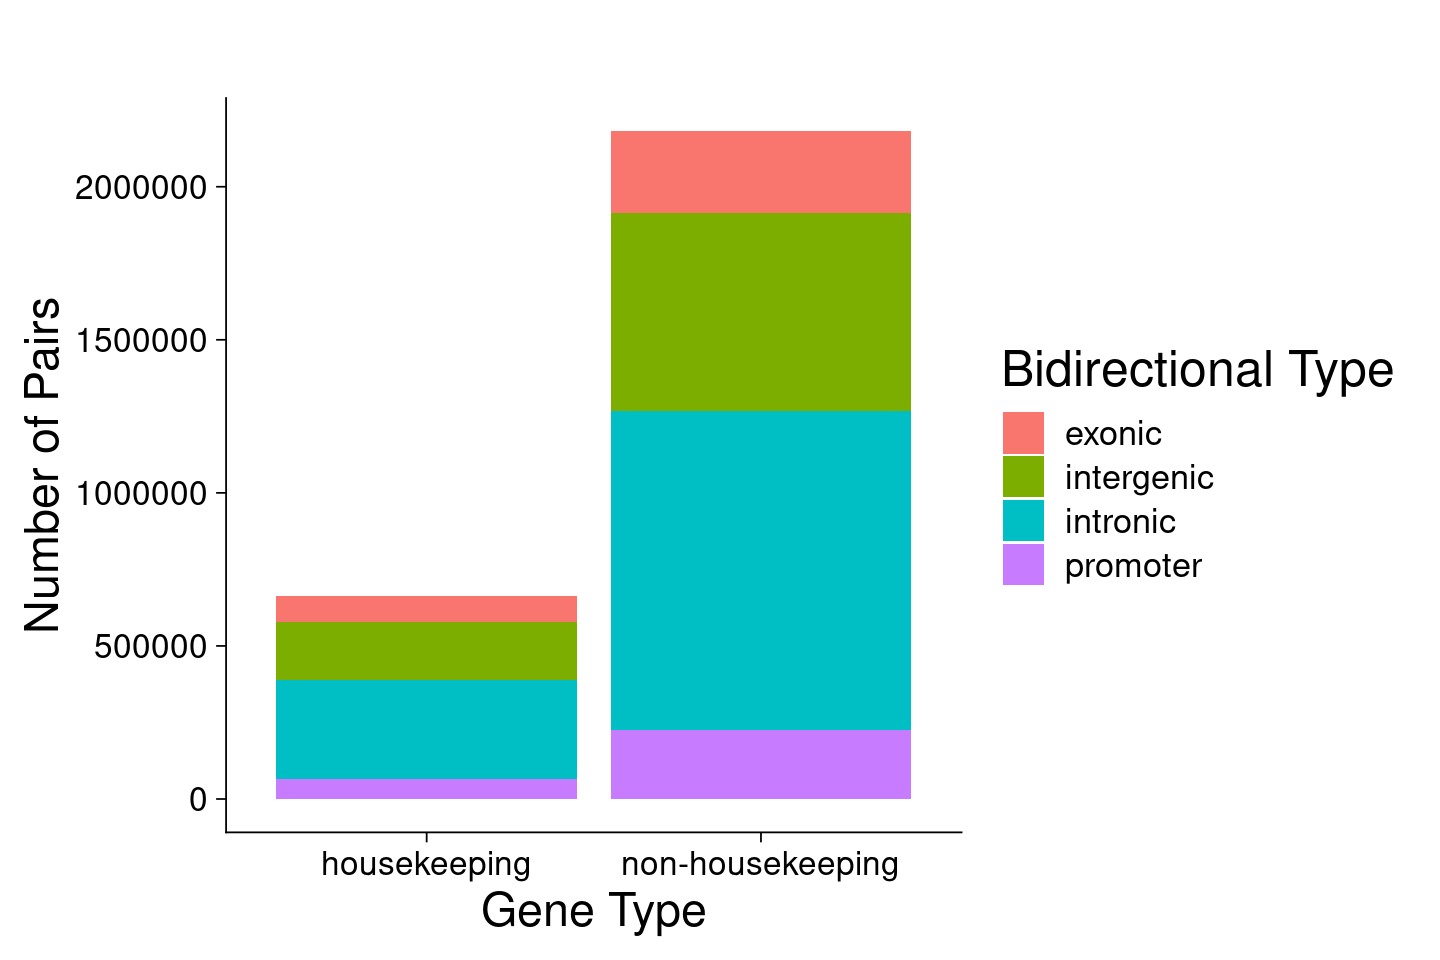

In [63]:
options(repr.plot.width=12, repr.plot.height=8)

ggplot(gene_bidir_type_summary,
       aes(fill=transcript_type, y=Freq, x=gene_type)) + 
    geom_bar(position="stack", stat="identity")+
labs(title = " ", 
       y = "Number of Pairs",
       x = "Gene Type",
    fill="Bidirectional Type") +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 20),
      axis.text.x = element_text(size = 20)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

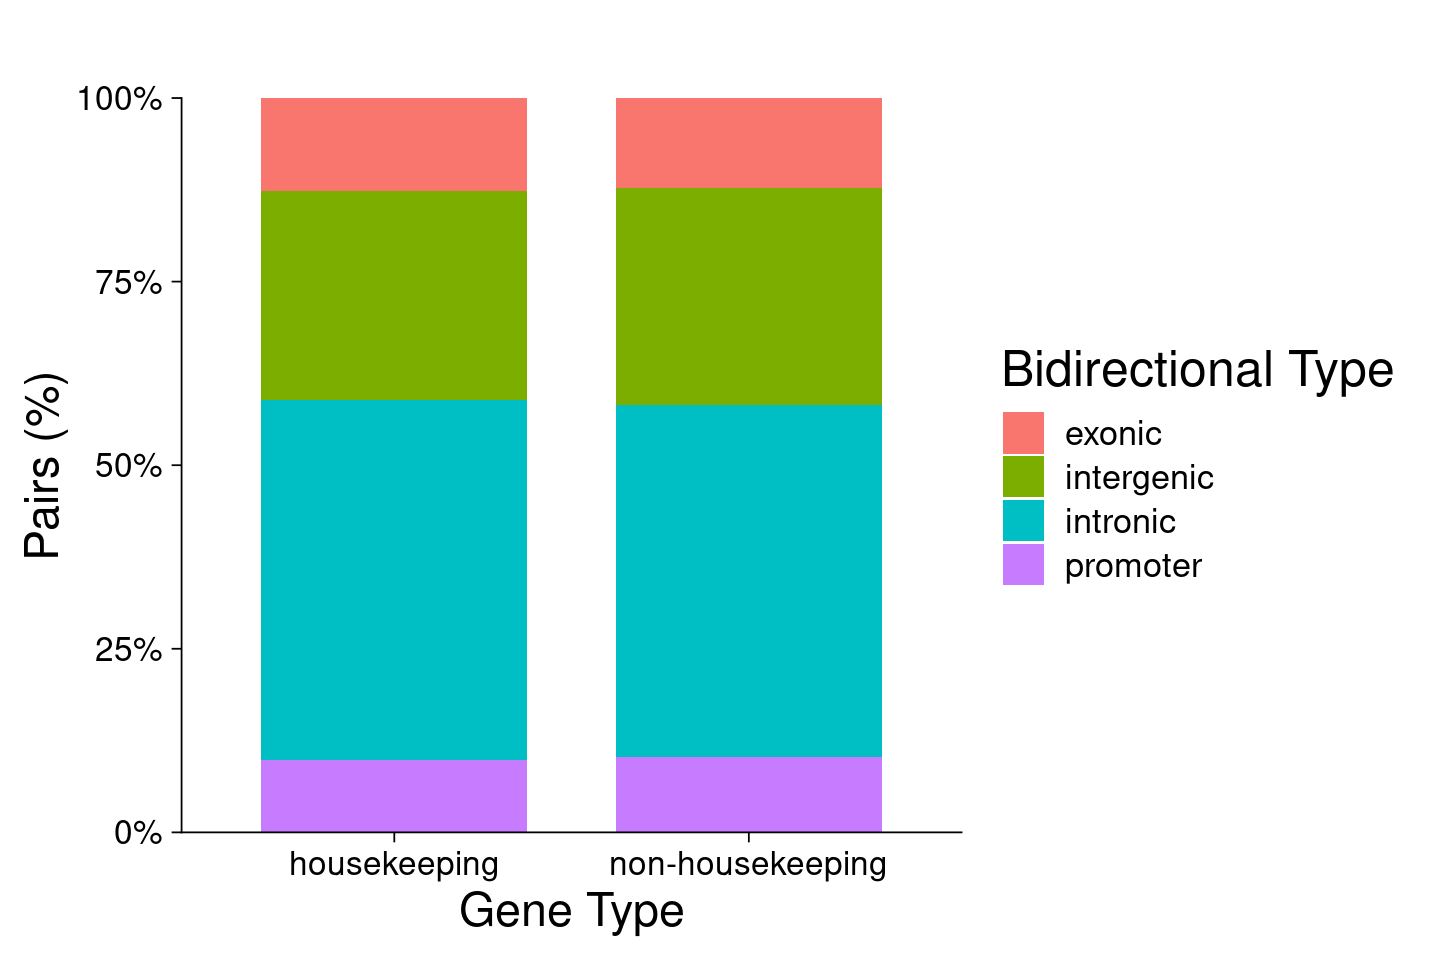

In [64]:
options(repr.plot.width=12, repr.plot.height=8)

ggplot(gene_bidir_type_summary,
       aes(x=gene_type, y = Freq, fill=transcript_type)) + 
geom_bar(position="fill", stat="identity", width=0.75) +
labs(title = " ", 
       y = "Pairs (%)",
       x = "Gene Type",
    fill="Bidirectional Type") +
theme_cowplot(24) +
scale_y_continuous(labels = scales::percent, expand=c(0,0)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 20),
      axis.text.x = element_text(size = 20)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

# Bidirectionals assigned to gene

In [65]:
#get unique pairs
corr_sig_DT_loop_unique <- unique(corr_sig_DT_loop[,c('pair_id',
                                            'transcript_1', 
                                            'transcript_2')])



corr_sig_DT_loop_unique_bidirtype <- merge(corr_sig_DT_loop_unique, 
                                     gene_bidir_types,  
                                     by.x="transcript_2",
                                     by.y="gene_transcript")
dim(corr_sig_DT_loop_unique_bidirtype)
head(corr_sig_DT_loop_unique_bidirtype)

[1] 2843202       4

transcript_2,pair_id,transcript_1,transcript_type
<chr>,<chr>,<chr>,<chr>
chr10:100000773-100001115,COX15:NM_004376.7~chr10:100000773-100001115,COX15:NM_004376.7,intronic
chr10:100000773-100001115,ERLIN1:NM_006459.4~chr10:100000773-100001115,ERLIN1:NM_006459.4,intronic
chr10:100000773-100001115,CHUK:NM_001278.5~chr10:100000773-100001115,CHUK:NM_001278.5,intronic
chr10:100000773-100001115,NDUFB8:NM_005004.4~chr10:100000773-100001115,NDUFB8:NM_005004.4,intronic
chr10:100001829-100002093,DNMBP-AS1:NR_024130.3~chr10:100001829-100002093,DNMBP-AS1:NR_024130.3,intronic
chr10:100003000-100003280,DNMBP-AS1:NR_024130.3~chr10:100003000-100003280,DNMBP-AS1:NR_024130.3,intronic


In [66]:
#get gene ids without the transcript ID
corr_sig_DT_loop_unique_bidirtype$gene_id <- as.character(lapply(strsplit(corr_sig_DT_loop_unique_bidirtype$transcript_1, ':'),
                                                    `[`, 1)) 

#merge with housekeeping gene IDs
corr_sig_DT_loop_unique_bidirtype$gene_type <- ifelse(corr_sig_DT_loop_unique_bidirtype$gene_id %in% gtex_low_gc$Genes,
                                              "housekeeping", "non-housekeeping")
head(corr_sig_DT_loop_unique_bidirtype)

transcript_2,pair_id,transcript_1,transcript_type,gene_id,gene_type
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr10:100000773-100001115,COX15:NM_004376.7~chr10:100000773-100001115,COX15:NM_004376.7,intronic,COX15,housekeeping
chr10:100000773-100001115,ERLIN1:NM_006459.4~chr10:100000773-100001115,ERLIN1:NM_006459.4,intronic,ERLIN1,non-housekeeping
chr10:100000773-100001115,CHUK:NM_001278.5~chr10:100000773-100001115,CHUK:NM_001278.5,intronic,CHUK,housekeeping
chr10:100000773-100001115,NDUFB8:NM_005004.4~chr10:100000773-100001115,NDUFB8:NM_005004.4,intronic,NDUFB8,housekeeping
chr10:100001829-100002093,DNMBP-AS1:NR_024130.3~chr10:100001829-100002093,DNMBP-AS1:NR_024130.3,intronic,DNMBP-AS1,non-housekeeping
chr10:100003000-100003280,DNMBP-AS1:NR_024130.3~chr10:100003000-100003280,DNMBP-AS1:NR_024130.3,intronic,DNMBP-AS1,non-housekeeping


In [67]:
dim(corr_sig_DT_loop_unique_bidirtype)

[1] 2843202       6

In [68]:
##count number of bidirs per gene
num_bidir_per_gene <- as.data.frame(table(corr_sig_DT_loop_unique$transcript_1))

##get gene ids
num_bidir_per_gene$gene_id <- as.character(lapply(strsplit(as.character(num_bidir_per_gene$Var1), ':'),
                                                    `[`, 1)) 

##annotate house keeping genes
num_bidir_per_gene$gene_type <- ifelse(num_bidir_per_gene$gene_id %in% gtex_low_gc$Genes,
                                       "housekeeping",
                                       "non-housekeeping")

dim(num_bidir_per_gene)
head(num_bidir_per_gene)

[1] 22503     4

,Var1,Freq,gene_id,gene_type
,<fct>,<int>,<chr>,<chr>
1,A1BG-AS1:NR_015380.2,198,A1BG-AS1,non-housekeeping
2,A1BG:NM_130786.4,150,A1BG,non-housekeeping
3,A1CF:NM_014576.4,21,A1CF,non-housekeeping
4,A2M-AS1:NR_026971.1,151,A2M-AS1,non-housekeeping
5,A2M:NM_000014.6,51,A2M,non-housekeeping
6,A2ML1:NM_001282424.3,25,A2ML1,non-housekeeping


In [69]:
table(num_bidir_per_gene$gene_type)


    housekeeping non-housekeeping 
            3449            19054 

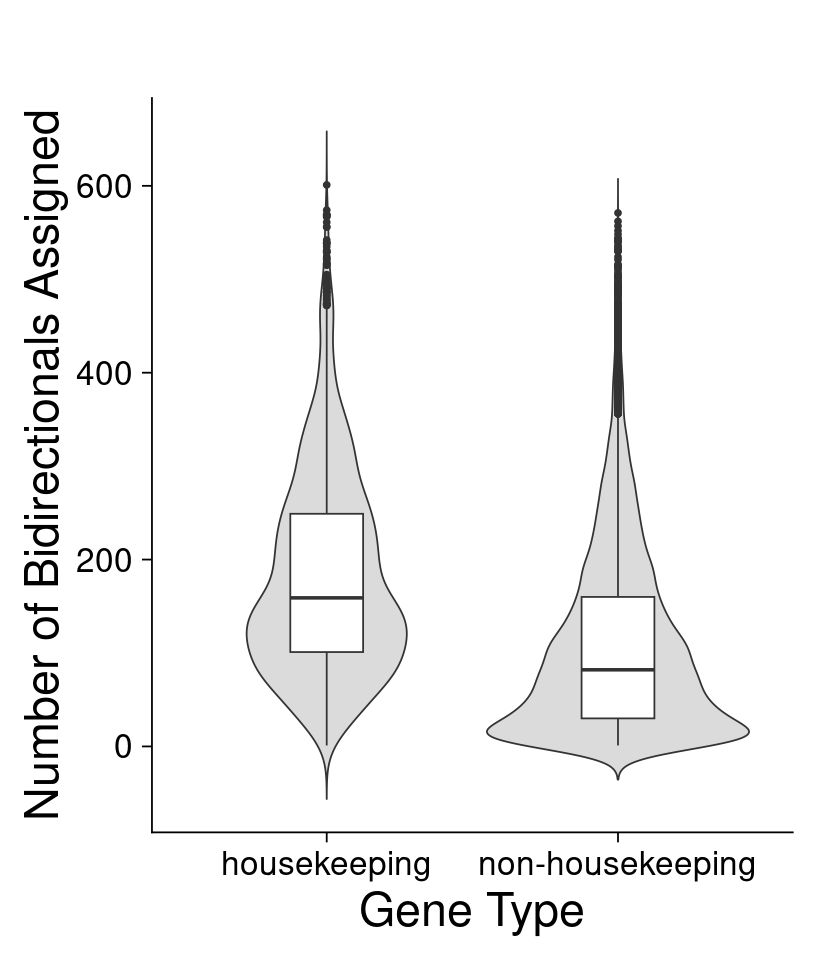

In [70]:
options(repr.plot.width=7, repr.plot.height=8)

# Use single color
housekeeping_num_bidir <- ggplot(num_bidir_per_gene, 
                                     aes(x=gene_type, y=Freq)) +
  geom_violin(trim=FALSE, color="gray20", fill="gray80", alpha=0.7)+
  geom_boxplot(width=0.25, fill="white", color="gray20") + 
labs(title = " ", 
       y = "Number of Bidirectionals Assigned",
       x = "Gene Type",
    fill=" ") +
#scale_y_continuous(limits=c(-0.1, 1)) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 20),
      axis.text.x = element_text(size = 20)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

housekeeping_num_bidir

# Check looped pairs

## Get looped pairs

In [71]:
corr_sig_loop_DT_list <- list()

for (i in names(corr_sig_DT_list)){

    #get loop pairs by tissue
    looped_tissue <- subset(overlap_looped_DT, 
                            tissue==i)
    
    #get bidirectional - gene pair tissues
    corr_sig_DT_tissue <- subset(corr_sig_DT, tissue==i) 
    
    #subset the pairs with loop by tissue
    corr_sig_DT_tissue_loop <- corr_sig_DT_tissue[corr_sig_DT_tissue$pair_id %in%
                                                 looped_tissue$pair_id,]
    
    #save pairs with loop by tissue
    corr_sig_loop_DT_list[[i]] <- corr_sig_DT_tissue_loop
    
}

In [72]:
lapply(corr_sig_loop_DT_list, nrow)

$blood
[1] 1081967

$breast
[1] 864844

$embryo
[1] 54144

$heart
[1] 219636

$intestine
[1] 436825

$kidney
[1] 559170

$lung
[1] 106708

$prostate
[1] 521846

$skin
[1] 118496

$`umbilical cord`
[1] 120480

$uterus
[1] 261279

In [73]:
corr_sig_loop_DT <- do.call(rbind,corr_sig_loop_DT_list)
dim(corr_sig_loop_DT)

[1] 4345395      24

## Subset the tissues with high sample count

In [74]:
corr_sig_loop_sampled_DT <- corr_sig_loop_DT[corr_sig_loop_DT$tissue %in%
                                             c("prostate","breast","kidney",
                                               "blood","intestine","lung"),]
dim(corr_sig_loop_sampled_DT)
length(unique(corr_sig_loop_sampled_DT$pair_id))

[1] 3571360      24

[1] 2256346

## Count number of tissues a pair is found

In [75]:
no_tissues_for_pair <- as.data.frame(table(corr_sig_loop_sampled_DT$pair_id))
nrow(no_tissues_for_pair)
head(no_tissues_for_pair, 3)

[1] 2256346

,Var1,Freq
,<fct>,<int>
1,A1BG-AS1:NR_015380.2~chr19:57363902-57364246,1
2,A1BG-AS1:NR_015380.2~chr19:57429748-57430210,2
3,A1BG-AS1:NR_015380.2~chr19:57442340-57442746,1


In [76]:
no_tissues_for_pair$gene_id <- as.character(lapply(strsplit(as.character(no_tissues_for_pair$Var1), ':'),
                                                      `[`, 1))
no_tissues_for_pair$bidir_id <- as.character(lapply(strsplit(as.character(no_tissues_for_pair$Var1), '~'),
                                                      `[`, 2))
head(no_tissues_for_pair, 3)

,Var1,Freq,gene_id,bidir_id
,<fct>,<int>,<chr>,<chr>
1,A1BG-AS1:NR_015380.2~chr19:57363902-57364246,1,A1BG-AS1,chr19:57363902-57364246
2,A1BG-AS1:NR_015380.2~chr19:57429748-57430210,2,A1BG-AS1,chr19:57429748-57430210
3,A1BG-AS1:NR_015380.2~chr19:57442340-57442746,1,A1BG-AS1,chr19:57442340-57442746


### Get transcript SPECS

In [77]:
no_tissues_for_pair_specs <- merge(no_tissues_for_pair,
                                   spec_tissue_overlap,
                                   by.x="bidir_id",
                                  by.y="gene_transcript")
dim(no_tissues_for_pair_specs)

[1] 2256346      22

In [78]:
no_tissues_for_pair_specs$Freq <- factor(no_tissues_for_pair_specs$Freq,
                                        levels = c(1,2,3,4,5,6))
head(no_tissues_for_pair_specs)

,bidir_id,Var1,Freq,gene_id.x,blood,breast,embryo,heart,intestine,kidney,⋯,skin,umbilical cord,uterus,min,max,median,mean,gene_id.y,transcript_type,gene_type
,<chr>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,chr1:1000004-1000574,PERM1:NM_001369898.1~chr1:1000004-1000574,1,PERM1,0.2779087,0.4019825,0.1478186,0.3252155,0.7597242,0.8107646,⋯,0.5148886,0.4750387,0.7401973,0.1478186,0.8107646,0.408468,0.4727393,chr1,bidirectional,non-housekeeping
2,chr1:1000004-1000574,LOC107985728:NR_168405.1~chr1:1000004-1000574,1,LOC107985728,0.2779087,0.4019825,0.1478186,0.3252155,0.7597242,0.8107646,⋯,0.5148886,0.4750387,0.7401973,0.1478186,0.8107646,0.408468,0.4727393,chr1,bidirectional,non-housekeeping
3,chr1:1000004-1000574,SDF4:NM_016176.6~chr1:1000004-1000574,1,SDF4,0.2779087,0.4019825,0.1478186,0.3252155,0.7597242,0.8107646,⋯,0.5148886,0.4750387,0.7401973,0.1478186,0.8107646,0.408468,0.4727393,chr1,bidirectional,non-housekeeping
4,chr1:1000004-1000574,AURKAIP1:NM_017900.3~chr1:1000004-1000574,1,AURKAIP1,0.2779087,0.4019825,0.1478186,0.3252155,0.7597242,0.8107646,⋯,0.5148886,0.4750387,0.7401973,0.1478186,0.8107646,0.408468,0.4727393,chr1,bidirectional,non-housekeeping
5,chr1:1000004-1000574,MRPL20:NM_017971.4~chr1:1000004-1000574,1,MRPL20,0.2779087,0.4019825,0.1478186,0.3252155,0.7597242,0.8107646,⋯,0.5148886,0.4750387,0.7401973,0.1478186,0.8107646,0.408468,0.4727393,chr1,bidirectional,non-housekeeping
6,chr1:1000004-1000574,KLHL17:NM_198317.3~chr1:1000004-1000574,1,KLHL17,0.2779087,0.4019825,0.1478186,0.3252155,0.7597242,0.8107646,⋯,0.5148886,0.4750387,0.7401973,0.1478186,0.8107646,0.408468,0.4727393,chr1,bidirectional,non-housekeeping


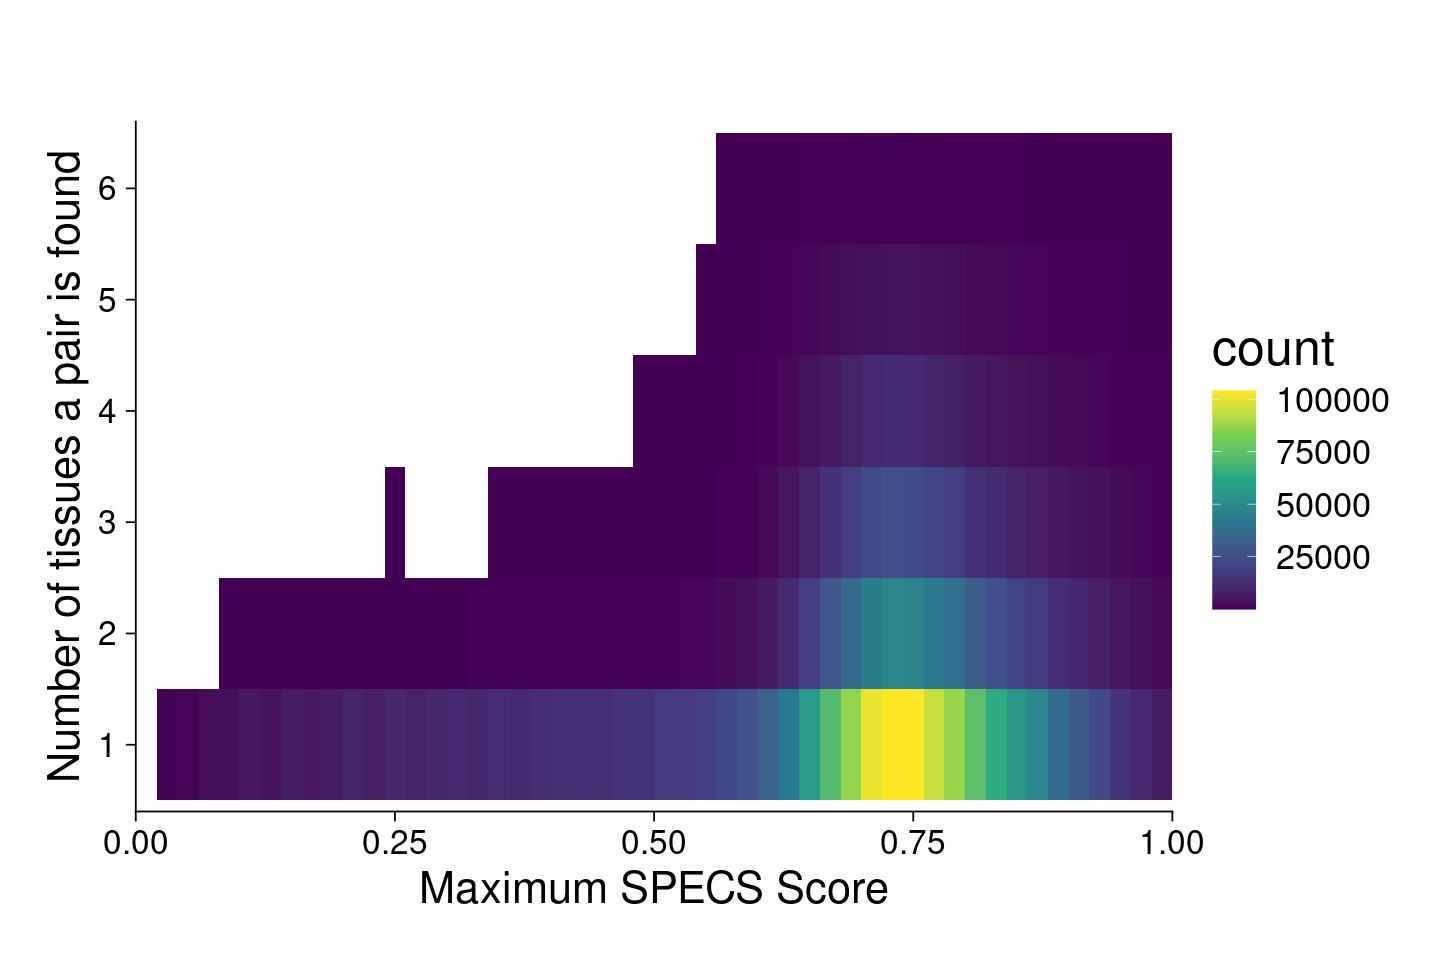

In [79]:
options(repr.plot.width=12, repr.plot.height=8)

no_tissues_for_pair_specs_plot <- ggplot(no_tissues_for_pair_specs, 
                                         aes(x = max, 
                                             y = Freq)) + 
geom_bin2d(bins = 50) +
  scale_fill_continuous(type = "viridis") +
geom_vline(xintercept = 0,
           linetype="dashed", 
           color = "white", 
           linewidth=0.5) +
theme_cowplot(24)+
scale_x_continuous(expand = c(0, 0)) +
#scale_y_continuous(expand = c(0, 0)) +
ggtitle(" ") +
xlab("Maximum SPECS Score") +
ylab("Number of tissues a pair is found") +
theme(plot.title = element_text(hjust = 0.5, face='plain'),
      title = element_text(size = 30), 
      axis.title = element_text(size = 26), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) +
theme(plot.margin = margin(1,1,1,1, "cm"))

no_tissues_for_pair_specs_plot

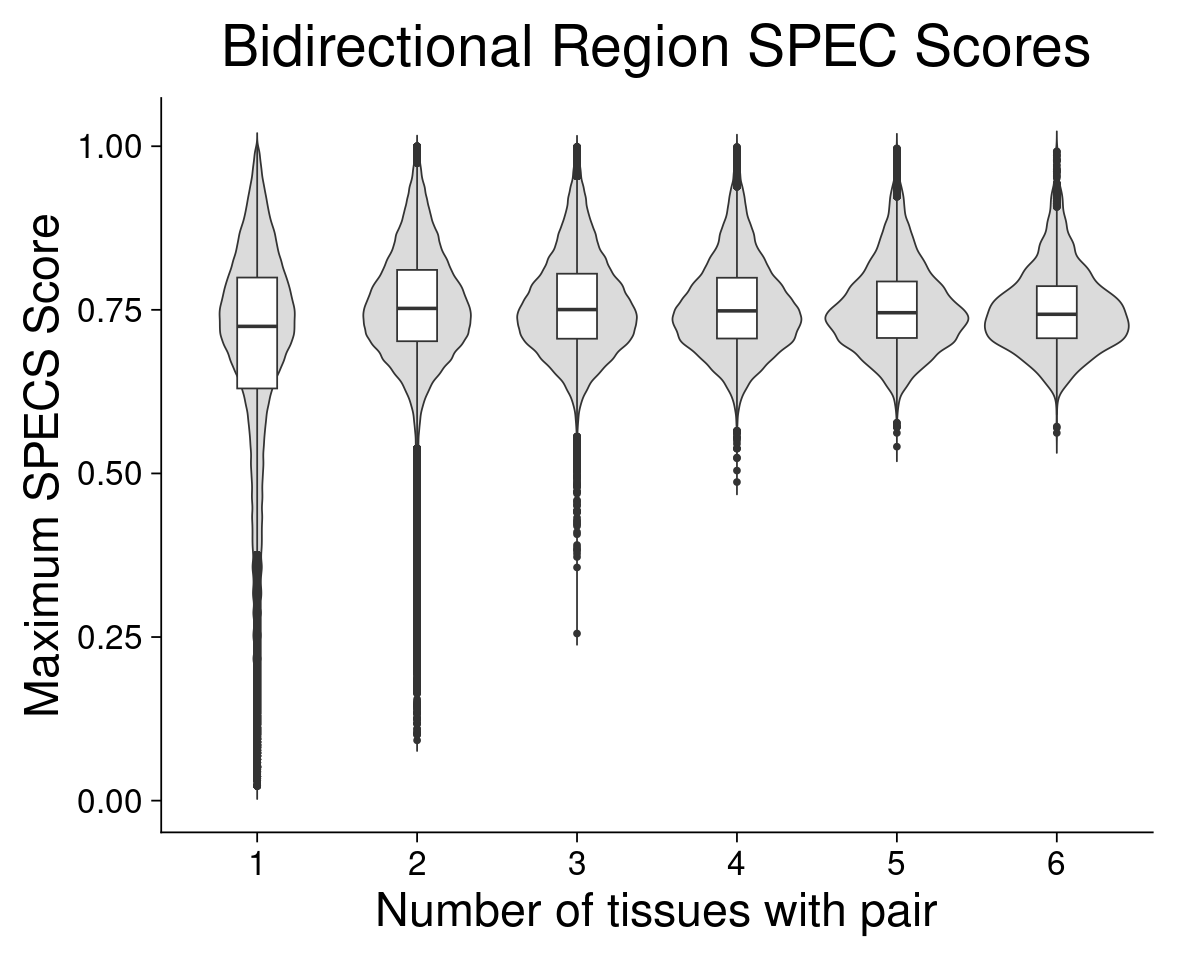

In [80]:
options(repr.plot.width=10, repr.plot.height=8)

# Use single color
no_tissues_for_pair_specs_boxplot <- ggplot(no_tissues_for_pair_specs, 
                                     aes(x=Freq, y=max)) +
  geom_violin(trim=FALSE, color="gray20", fill="gray80", alpha=0.7)+
  geom_boxplot(width=0.25, fill="white", color="gray20") + 
labs(title = "Bidirectional Region SPEC Scores", 
       y = "Maximum SPECS Score",
       x = "Number of tissues with pair",
    fill=" ") +
#scale_y_continuous(limits=c(-0.1, 1)) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 20),
      axis.text.x = element_text(size = 20)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

no_tissues_for_pair_specs_boxplot

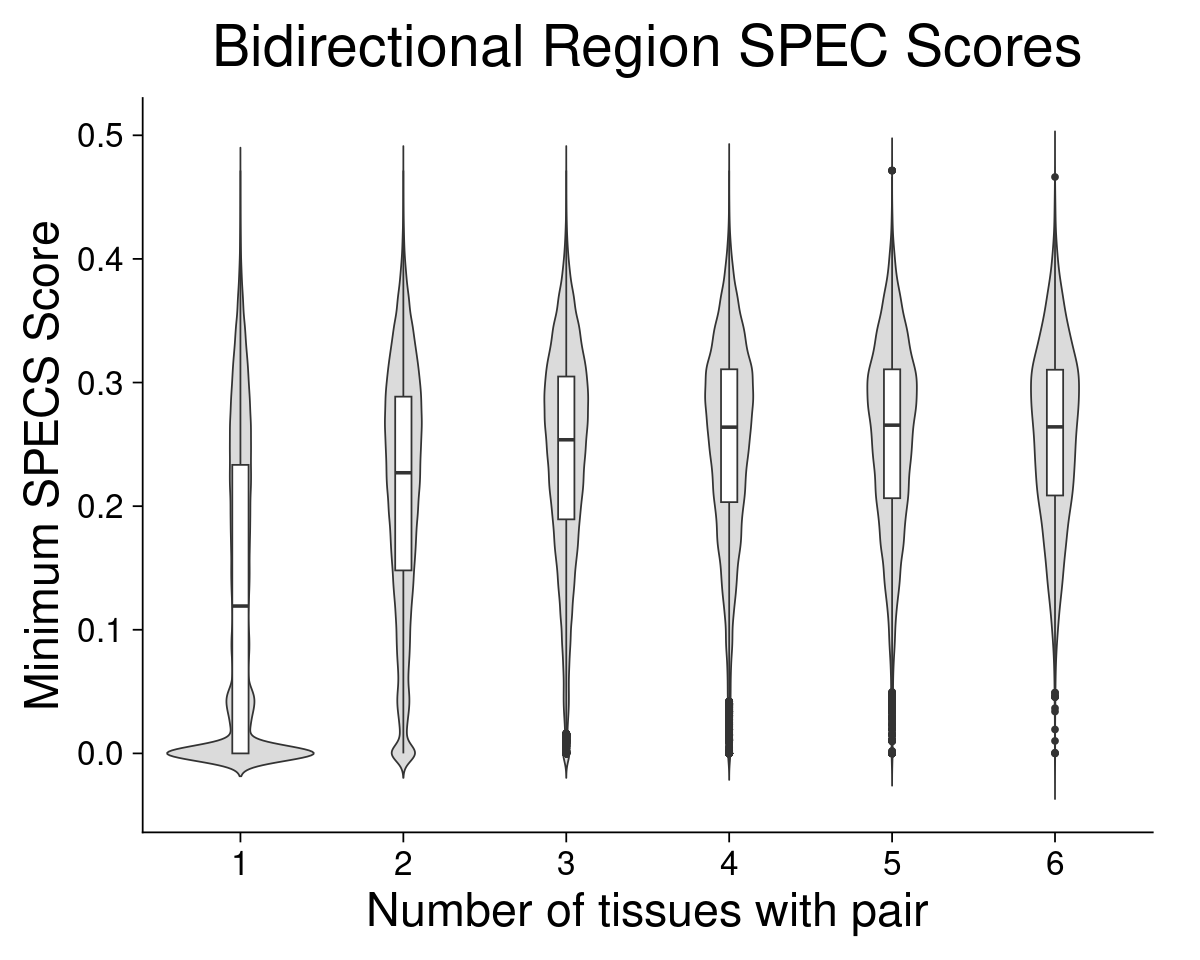

In [81]:
options(repr.plot.width=10, repr.plot.height=8)

# Use single color
no_tissues_for_pair_minspecs_boxplot <- ggplot(no_tissues_for_pair_specs, 
                                     aes(x=Freq, y=min)) +
  geom_violin(trim=FALSE, color="gray20", fill="gray80", alpha=0.7)+
  geom_boxplot(width=0.1, fill="white", color="gray20") + 
labs(title = "Bidirectional Region SPEC Scores", 
       y = "Minimum SPECS Score",
       x = "Number of tissues with pair",
    fill=" ") +
#scale_y_continuous(limits=c(-0.1, 1)) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 20),
      axis.text.x = element_text(size = 20)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

no_tissues_for_pair_minspecs_boxplot

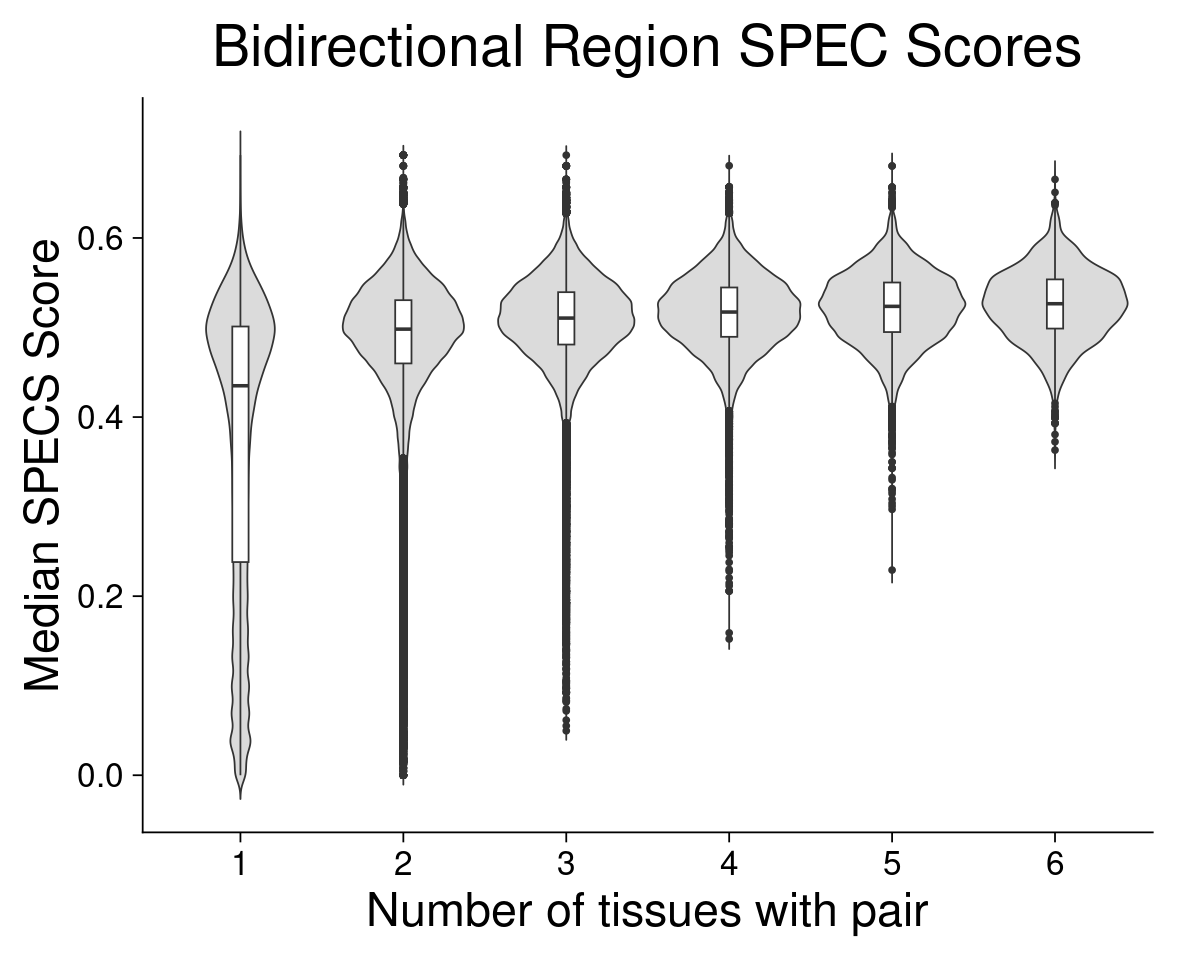

In [82]:
options(repr.plot.width=10, repr.plot.height=8)

# Use single color
no_tissues_for_pair_medspecs_boxplot <- ggplot(no_tissues_for_pair_specs, 
                                     aes(x=Freq, y=median)) +
  geom_violin(trim=FALSE, color="gray20", fill="gray80", alpha=0.7)+
  geom_boxplot(width=0.1, fill="white", color="gray20") + 
labs(title = "Bidirectional Region SPEC Scores", 
       y = "Median SPECS Score",
       x = "Number of tissues with pair",
    fill=" ") +
#scale_y_continuous(limits=c(-0.1, 1)) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 20),
      axis.text.x = element_text(size = 20)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

no_tissues_for_pair_medspecs_boxplot

In [83]:
no_tissues_for_pair_genespecs <- merge(no_tissues_for_pair,
                                   spec_tissue_overlap,
                                   by.x="gene_id",
                                  by.y="gene_id")
dim(no_tissues_for_pair_genespecs)

[1] 2256346      22

In [84]:
no_tissues_for_pair_genespecs$Freq <- factor(no_tissues_for_pair_genespecs$Freq,
                                        levels = c(1,2,3,4,5,6))
head(no_tissues_for_pair_genespecs)

,gene_id,Var1,Freq,bidir_id,gene_transcript,blood,breast,embryo,heart,intestine,⋯,prostate,skin,umbilical cord,uterus,min,max,median,mean,transcript_type,gene_type
,<chr>,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,A1BG,A1BG:NM_130786.4~chr19:57447946-57448224,1,chr19:57447946-57448224,A1BG:NM_130786.4,0.6937246,0.6195393,0.3859654,0.5143949,0.2756093,⋯,0.450382,0.7116905,0.1345747,0.1470997,0.1345747,0.7930856,0.5143949,0.4848059,gene,non-housekeeping
2,A1BG,A1BG:NM_130786.4~chr19:57450214-57451156,1,chr19:57450214-57451156,A1BG:NM_130786.4,0.6937246,0.6195393,0.3859654,0.5143949,0.2756093,⋯,0.450382,0.7116905,0.1345747,0.1470997,0.1345747,0.7930856,0.5143949,0.4848059,gene,non-housekeeping
3,A1BG,A1BG:NM_130786.4~chr19:57507969-57508313,1,chr19:57507969-57508313,A1BG:NM_130786.4,0.6937246,0.6195393,0.3859654,0.5143949,0.2756093,⋯,0.450382,0.7116905,0.1345747,0.1470997,0.1345747,0.7930856,0.5143949,0.4848059,gene,non-housekeeping
4,A1BG,A1BG:NM_130786.4~chr19:57527152-57527546,3,chr19:57527152-57527546,A1BG:NM_130786.4,0.6937246,0.6195393,0.3859654,0.5143949,0.2756093,⋯,0.450382,0.7116905,0.1345747,0.1470997,0.1345747,0.7930856,0.5143949,0.4848059,gene,non-housekeeping
5,A1BG,A1BG:NM_130786.4~chr19:57581960-57582828,1,chr19:57581960-57582828,A1BG:NM_130786.4,0.6937246,0.6195393,0.3859654,0.5143949,0.2756093,⋯,0.450382,0.7116905,0.1345747,0.1470997,0.1345747,0.7930856,0.5143949,0.4848059,gene,non-housekeeping
6,A1BG,A1BG:NM_130786.4~chr19:57664288-57664636,1,chr19:57664288-57664636,A1BG:NM_130786.4,0.6937246,0.6195393,0.3859654,0.5143949,0.2756093,⋯,0.450382,0.7116905,0.1345747,0.1470997,0.1345747,0.7930856,0.5143949,0.4848059,gene,non-housekeeping


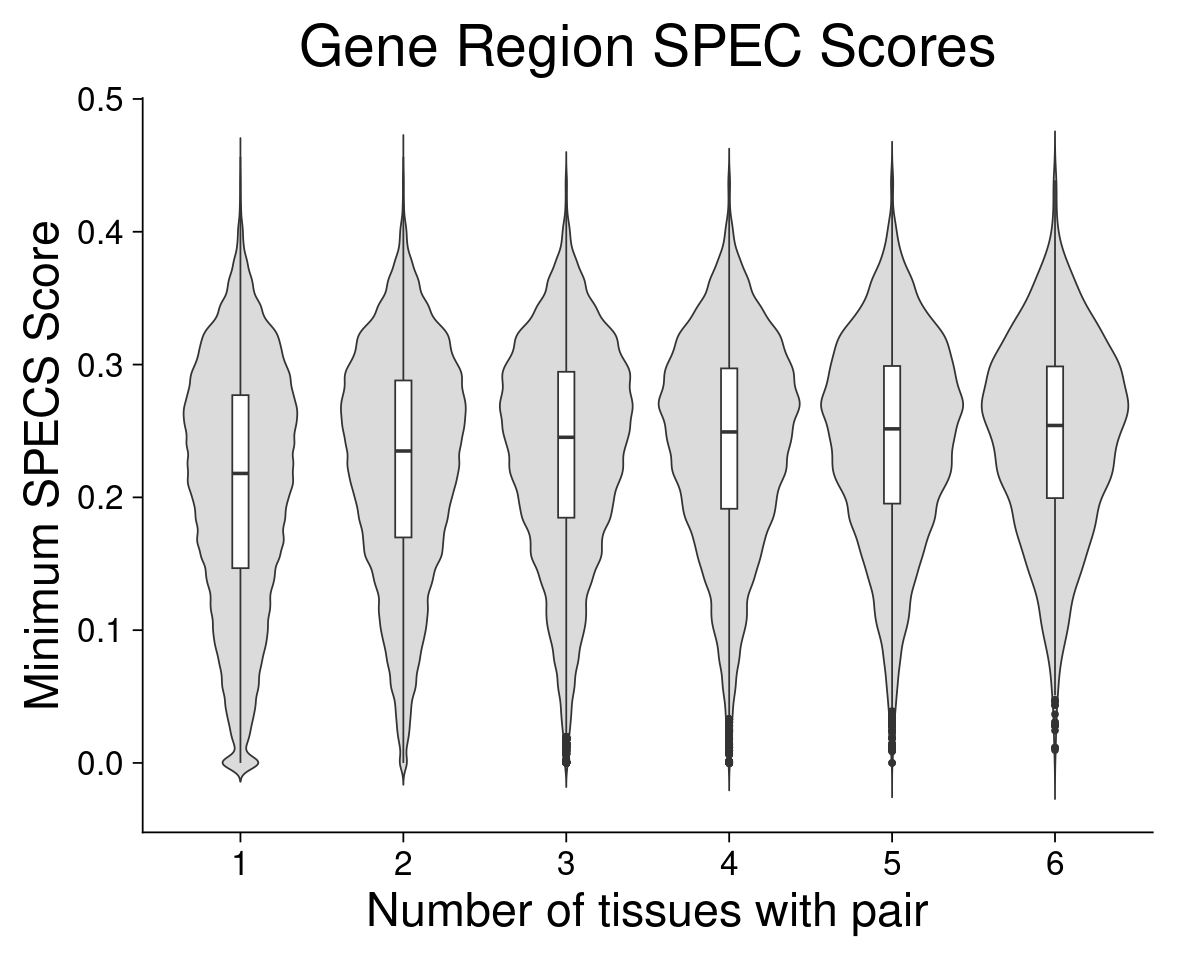

In [85]:
options(repr.plot.width=10, repr.plot.height=8)

# Use single color
gene_no_tissues_for_pair_minspecs_boxplot <- ggplot(no_tissues_for_pair_genespecs, 
                                     aes(x=Freq, y=min)) +
  geom_violin(trim=FALSE, color="gray20", fill="gray80", alpha=0.7)+
  geom_boxplot(width=0.1, fill="white", color="gray20") + 
labs(title = "Gene Region SPEC Scores", 
       y = "Minimum SPECS Score",
       x = "Number of tissues with pair",
    fill=" ") +
#scale_y_continuous(limits=c(-0.1, 1)) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 20),
      axis.text.x = element_text(size = 20)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

gene_no_tissues_for_pair_minspecs_boxplot

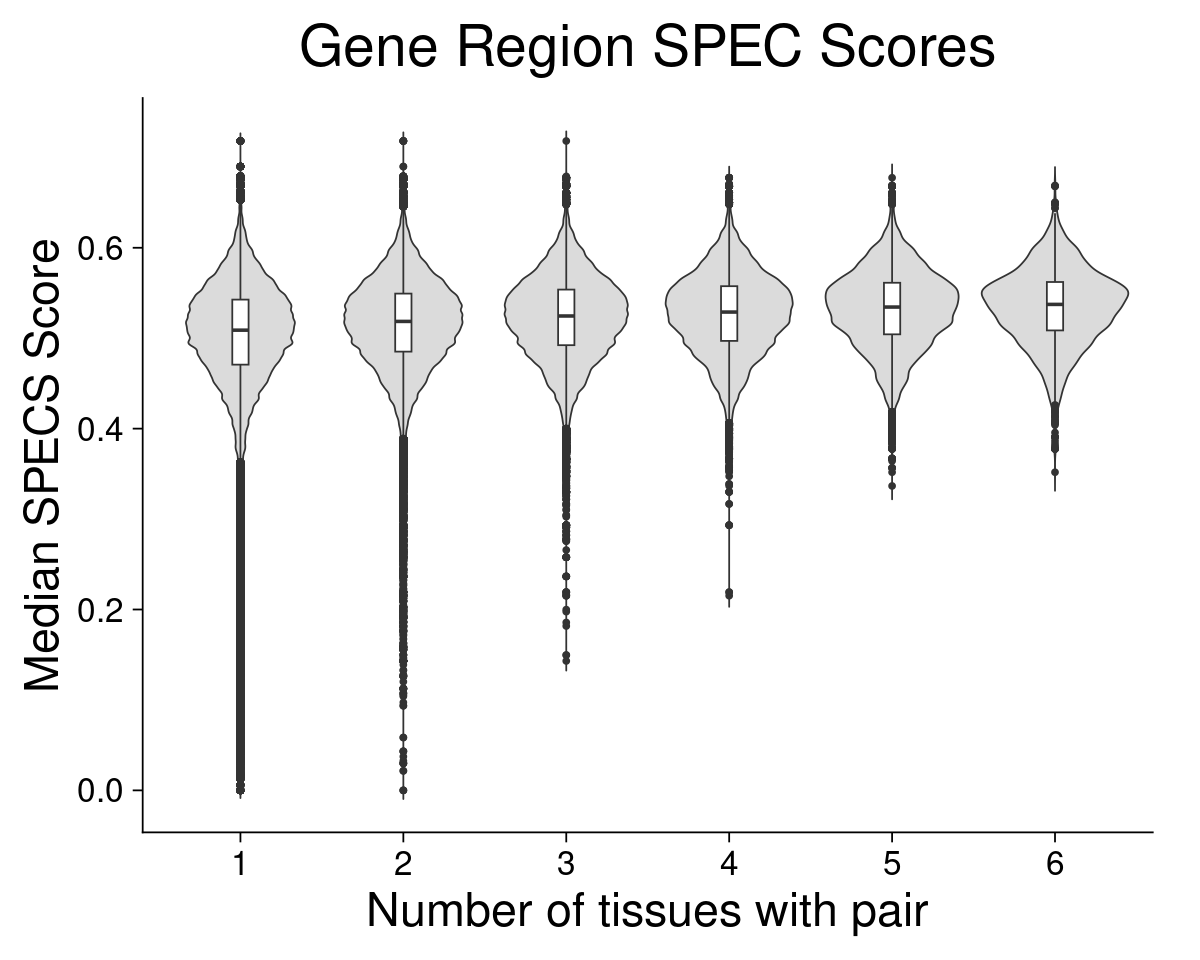

In [86]:
options(repr.plot.width=10, repr.plot.height=8)

# Use single color
gene_no_tissues_for_pair_medspecs_boxplot <- ggplot(no_tissues_for_pair_genespecs, 
                                     aes(x=Freq, y=median)) +
  geom_violin(trim=FALSE, color="gray20", fill="gray80", alpha=0.7)+
  geom_boxplot(width=0.1, fill="white", color="gray20") + 
labs(title = "Gene Region SPEC Scores", 
       y = "Median SPECS Score",
       x = "Number of tissues with pair",
    fill=" ") +
#scale_y_continuous(limits=c(-0.1, 1)) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 20),
      axis.text.x = element_text(size = 20)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

gene_no_tissues_for_pair_medspecs_boxplot

In [87]:
dim(no_tissues_for_pair_specs)
dim(no_tissues_for_pair_genespecs)

[1] 2256346      22

[1] 2256346      22

In [88]:
head(no_tissues_for_pair_specs, 2)
head(no_tissues_for_pair_genespecs, 2)

,bidir_id,Var1,Freq,gene_id.x,blood,breast,embryo,heart,intestine,kidney,⋯,skin,umbilical cord,uterus,min,max,median,mean,gene_id.y,transcript_type,gene_type
,<chr>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,chr1:1000004-1000574,PERM1:NM_001369898.1~chr1:1000004-1000574,1,PERM1,0.2779087,0.4019825,0.1478186,0.3252155,0.7597242,0.8107646,⋯,0.5148886,0.4750387,0.7401973,0.1478186,0.8107646,0.408468,0.4727393,chr1,bidirectional,non-housekeeping
2,chr1:1000004-1000574,LOC107985728:NR_168405.1~chr1:1000004-1000574,1,LOC107985728,0.2779087,0.4019825,0.1478186,0.3252155,0.7597242,0.8107646,⋯,0.5148886,0.4750387,0.7401973,0.1478186,0.8107646,0.408468,0.4727393,chr1,bidirectional,non-housekeeping


,gene_id,Var1,Freq,bidir_id,gene_transcript,blood,breast,embryo,heart,intestine,⋯,prostate,skin,umbilical cord,uterus,min,max,median,mean,transcript_type,gene_type
,<chr>,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,A1BG,A1BG:NM_130786.4~chr19:57447946-57448224,1,chr19:57447946-57448224,A1BG:NM_130786.4,0.6937246,0.6195393,0.3859654,0.5143949,0.2756093,⋯,0.450382,0.7116905,0.1345747,0.1470997,0.1345747,0.7930856,0.5143949,0.4848059,gene,non-housekeeping
2,A1BG,A1BG:NM_130786.4~chr19:57450214-57451156,1,chr19:57450214-57451156,A1BG:NM_130786.4,0.6937246,0.6195393,0.3859654,0.5143949,0.2756093,⋯,0.450382,0.7116905,0.1345747,0.1470997,0.1345747,0.7930856,0.5143949,0.4848059,gene,non-housekeeping


In [89]:
num_tissues_specs_genes_bidirs <- rbind(no_tissues_for_pair_specs[,c("Var1","Freq","min",
                                                                  "max","mean","median", 
                                                                  "transcript_type")],
                                        no_tissues_for_pair_genespecs[,c("Var1","Freq","min",
                                                                      "max","mean","median", 
                                                                      "transcript_type")])
num_tissues_specs_genes_bidirs$transcript_type <- factor(num_tissues_specs_genes_bidirs$transcript_type,
                                                        levels=unique(num_tissues_specs_genes_bidirs$transcript_type))
dim(num_tissues_specs_genes_bidirs)
head(num_tissues_specs_genes_bidirs)

[1] 4512692       7

,Var1,Freq,min,max,mean,median,transcript_type
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,PERM1:NM_001369898.1~chr1:1000004-1000574,1,0.1478186,0.8107646,0.4727393,0.408468,bidirectional
2,LOC107985728:NR_168405.1~chr1:1000004-1000574,1,0.1478186,0.8107646,0.4727393,0.408468,bidirectional
3,SDF4:NM_016176.6~chr1:1000004-1000574,1,0.1478186,0.8107646,0.4727393,0.408468,bidirectional
4,AURKAIP1:NM_017900.3~chr1:1000004-1000574,1,0.1478186,0.8107646,0.4727393,0.408468,bidirectional
5,MRPL20:NM_017971.4~chr1:1000004-1000574,1,0.1478186,0.8107646,0.4727393,0.408468,bidirectional
6,KLHL17:NM_198317.3~chr1:1000004-1000574,1,0.1478186,0.8107646,0.4727393,0.408468,bidirectional


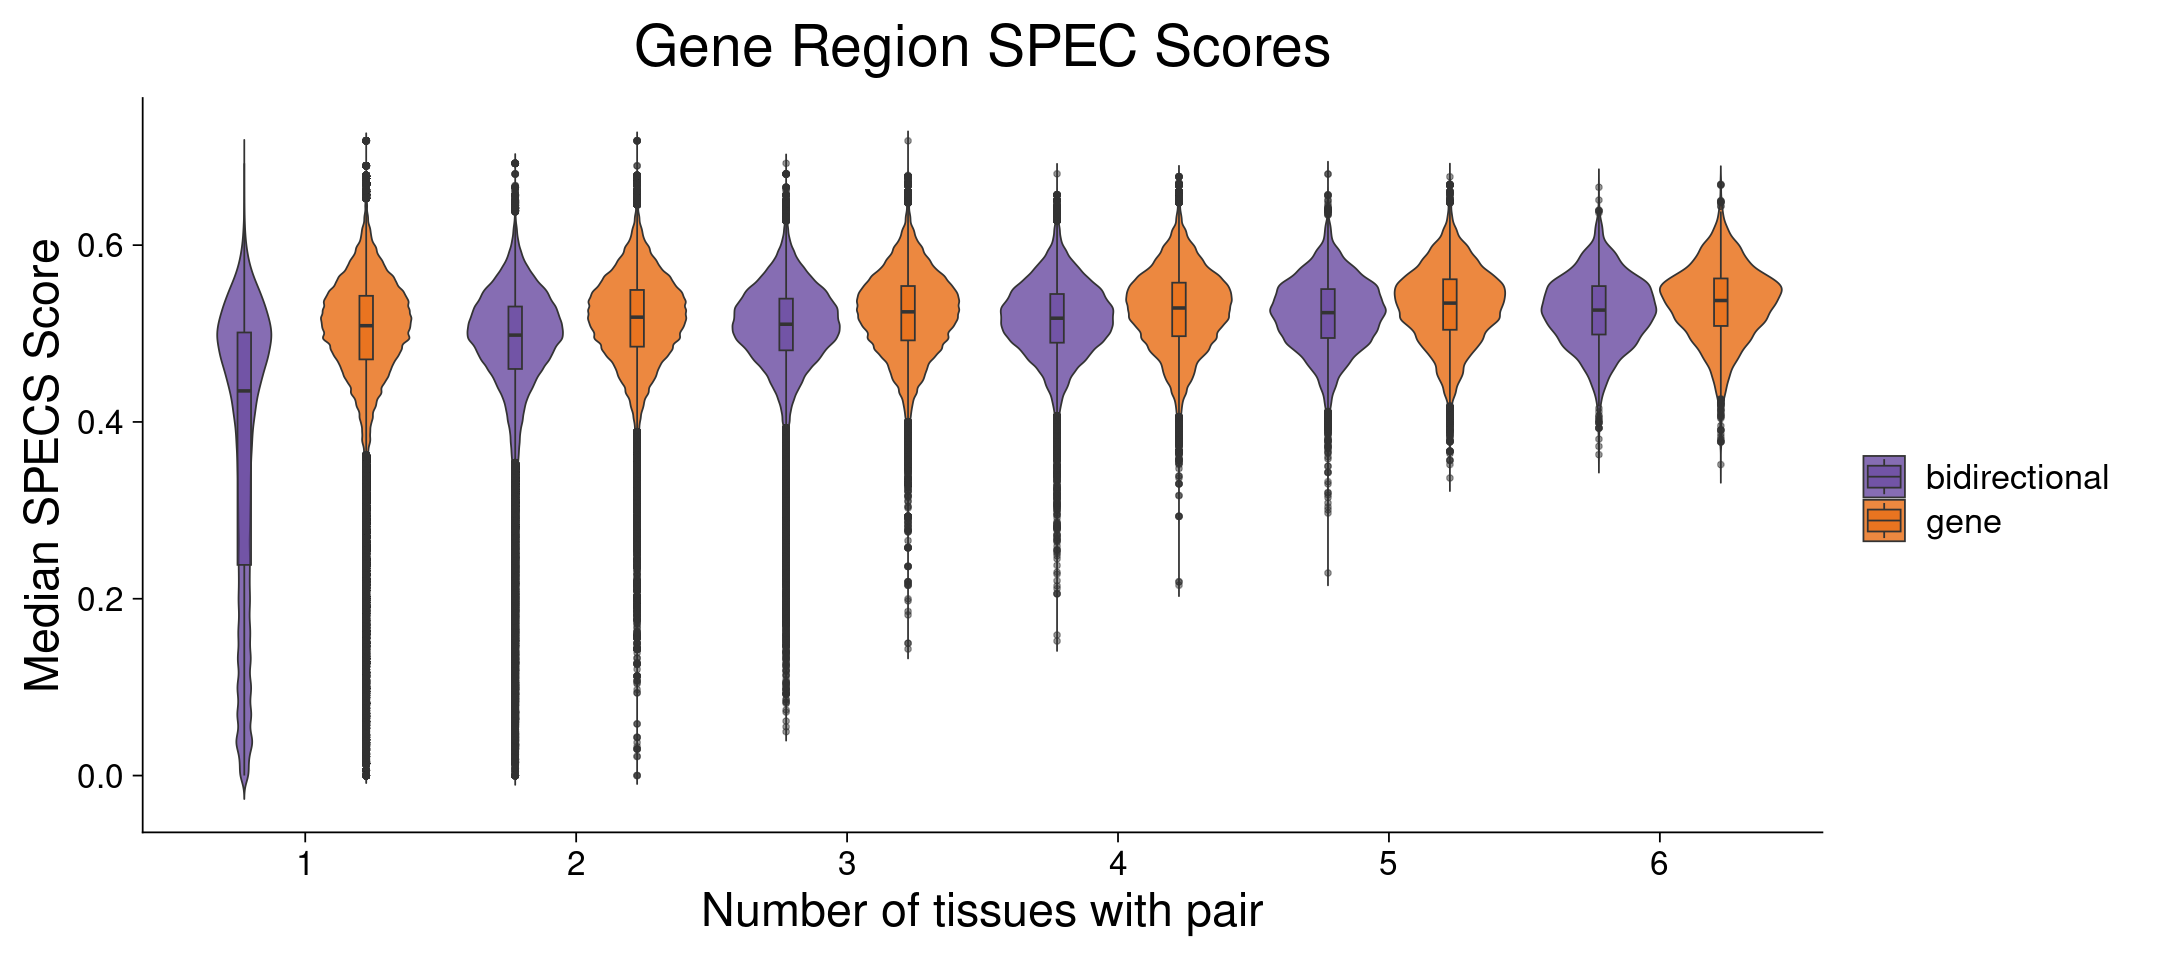

In [90]:
options(repr.plot.width=18, repr.plot.height=8)

# Use single color
gene_bidir_tissues_medspecs_boxplot <- ggplot(num_tissues_specs_genes_bidirs, 
                                     aes(x=Freq, y=median, 
                                         #group=transcript_type,
                                        fill=transcript_type)) +
  geom_violin(trim=FALSE, color="gray20", alpha=0.75, position = position_dodge(0.9))+
  geom_boxplot(width=0.1, color="gray20", alpha=0.5, position = position_dodge(0.9)) + 
labs(title = "Gene Region SPEC Scores", 
       y = "Median SPECS Score",
       x = "Number of tissues with pair",
    fill=" ") +
#scale_y_continuous(limits=c(-0.1, 1)) +
scale_fill_manual(values=c("#5e3c99","#e66101")) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 20),
      axis.text.x = element_text(size = 20)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

gene_bidir_tissues_medspecs_boxplot

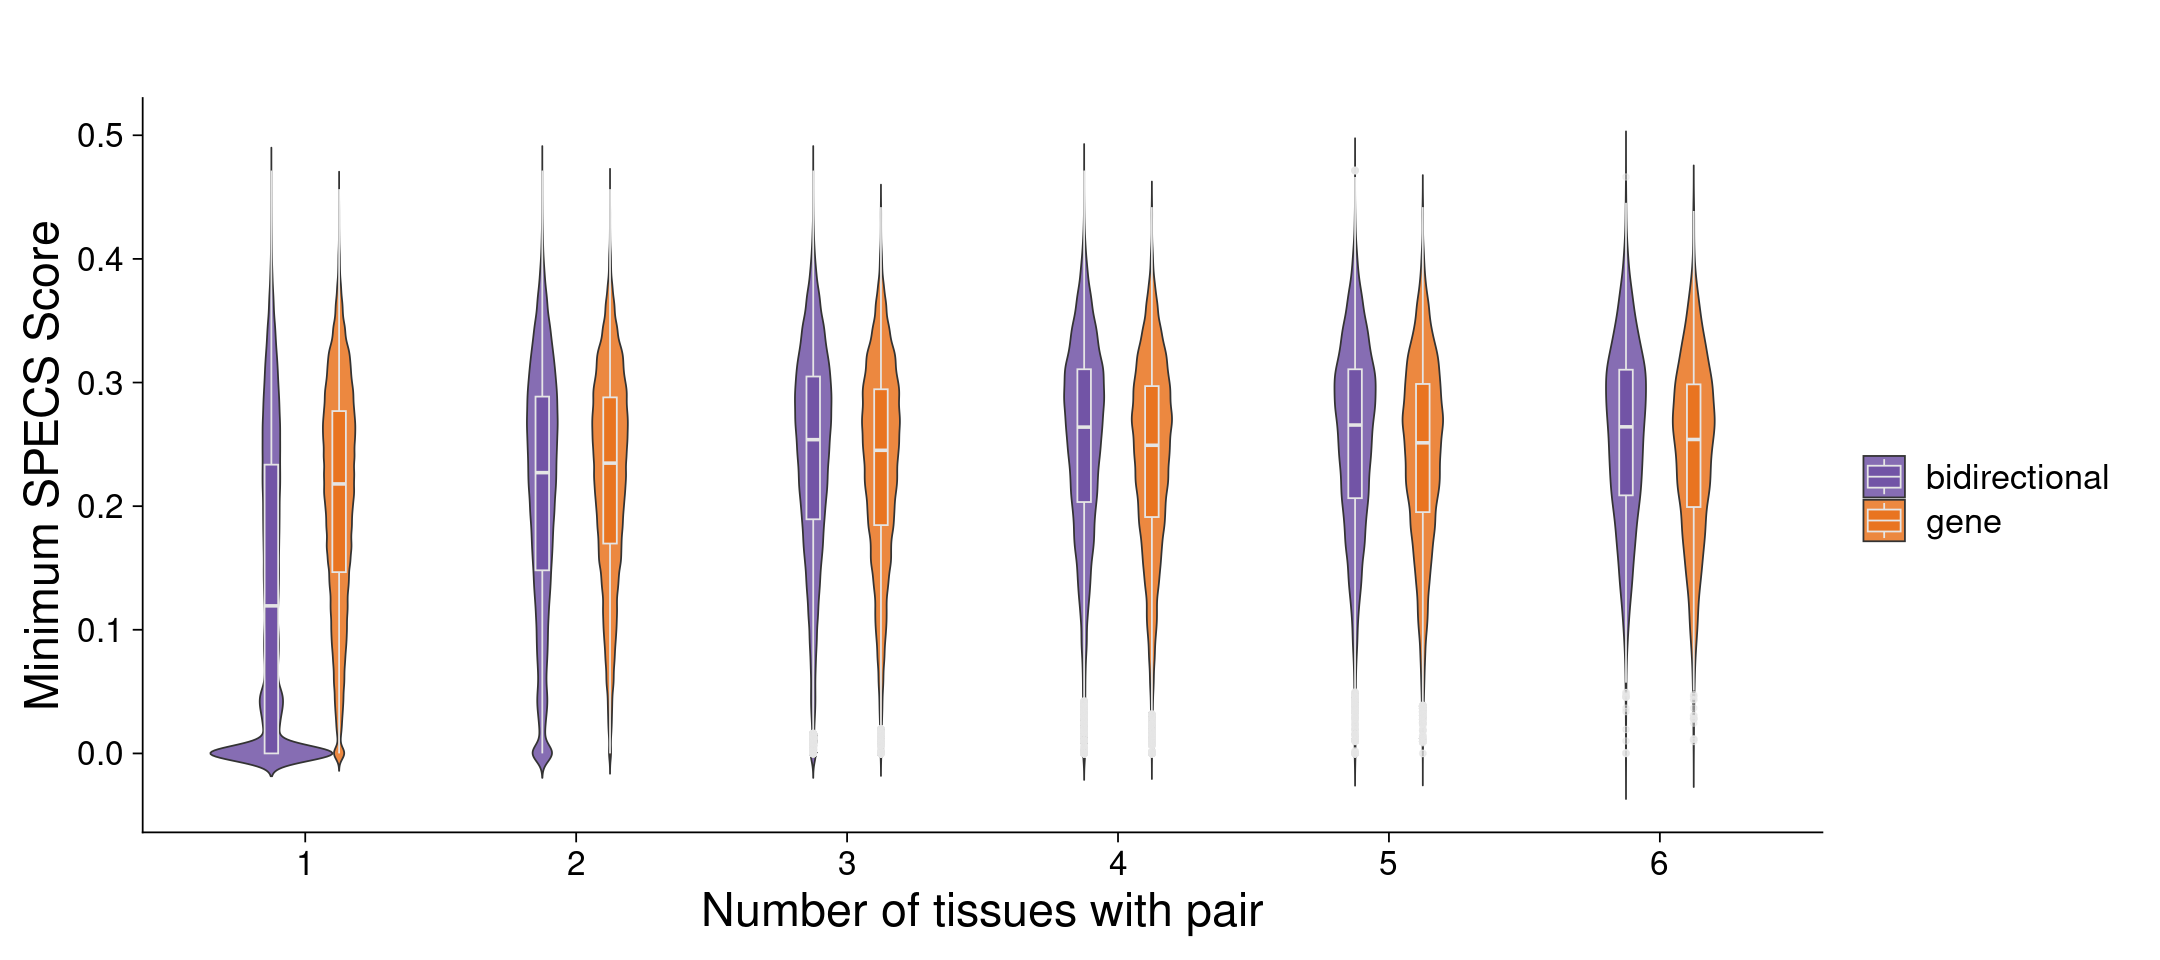

In [91]:
options(repr.plot.width=18, repr.plot.height=8)

# Use single color
gene_bidir_tissues_minspecs_boxplot <- ggplot(num_tissues_specs_genes_bidirs, 
                                     aes(x=Freq, y=min, 
                                         #group=transcript_type,
                                        fill=transcript_type)) +
  geom_violin(trim=FALSE, color="gray20", alpha=0.75, position = position_dodge(0.5))+
  geom_boxplot(width=0.1, color="gray90", alpha=0.5, position = position_dodge(0.5)) + 
labs(title = " ", 
       y = "Minimum SPECS Score",
       x = "Number of tissues with pair",
    fill=" ") +
#scale_y_continuous(limits=c(-0.1, 1)) +
scale_fill_manual(values=c("#5e3c99","#e66101")) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 20),
      axis.text.x = element_text(size = 20)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

gene_bidir_tissues_minspecs_boxplot

In [92]:
#function from: https://stackoverflow.com/questions/35717353/split-violin-plot-with-ggplot2

GeomSplitViolin <- ggproto("GeomSplitViolin", GeomViolin, 
                           draw_group = function(self, data, ..., draw_quantiles = NULL) {
  data <- transform(data, xminv = x - violinwidth * (x - xmin), xmaxv = x + violinwidth * (xmax - x))
  grp <- data[1, "group"]
  newdata <- plyr::arrange(transform(data, x = if (grp %% 2 == 1) xminv else xmaxv), if (grp %% 2 == 1) y else -y)
  newdata <- rbind(newdata[1, ], newdata, newdata[nrow(newdata), ], newdata[1, ])
  newdata[c(1, nrow(newdata) - 1, nrow(newdata)), "x"] <- round(newdata[1, "x"])

  if (length(draw_quantiles) > 0 & !scales::zero_range(range(data$y))) {
    stopifnot(all(draw_quantiles >= 0), all(draw_quantiles <=
      1))
    quantiles <- ggplot2:::create_quantile_segment_frame(data, draw_quantiles)
    aesthetics <- data[rep(1, nrow(quantiles)), setdiff(names(data), c("x", "y")), drop = FALSE]
    aesthetics$alpha <- rep(1, nrow(quantiles))
    both <- cbind(quantiles, aesthetics)
    quantile_grob <- GeomPath$draw_panel(both, ...)
    ggplot2:::ggname("geom_split_violin", grid::grobTree(GeomPolygon$draw_panel(newdata, ...), quantile_grob))
  }
  else {
    ggplot2:::ggname("geom_split_violin", GeomPolygon$draw_panel(newdata, ...))
  }
})

geom_split_violin <- function(mapping = NULL, data = NULL, stat = "ydensity", position = "identity", ..., 
                              draw_quantiles = NULL, trim = TRUE, scale = "area", na.rm = FALSE, 
                              show.legend = NA, inherit.aes = TRUE) {
  layer(data = data, mapping = mapping, stat = stat, geom = GeomSplitViolin, 
        position = position, show.legend = show.legend, inherit.aes = inherit.aes, 
        params = list(trim = trim, scale = scale, draw_quantiles = draw_quantiles, na.rm = na.rm, ...))
}

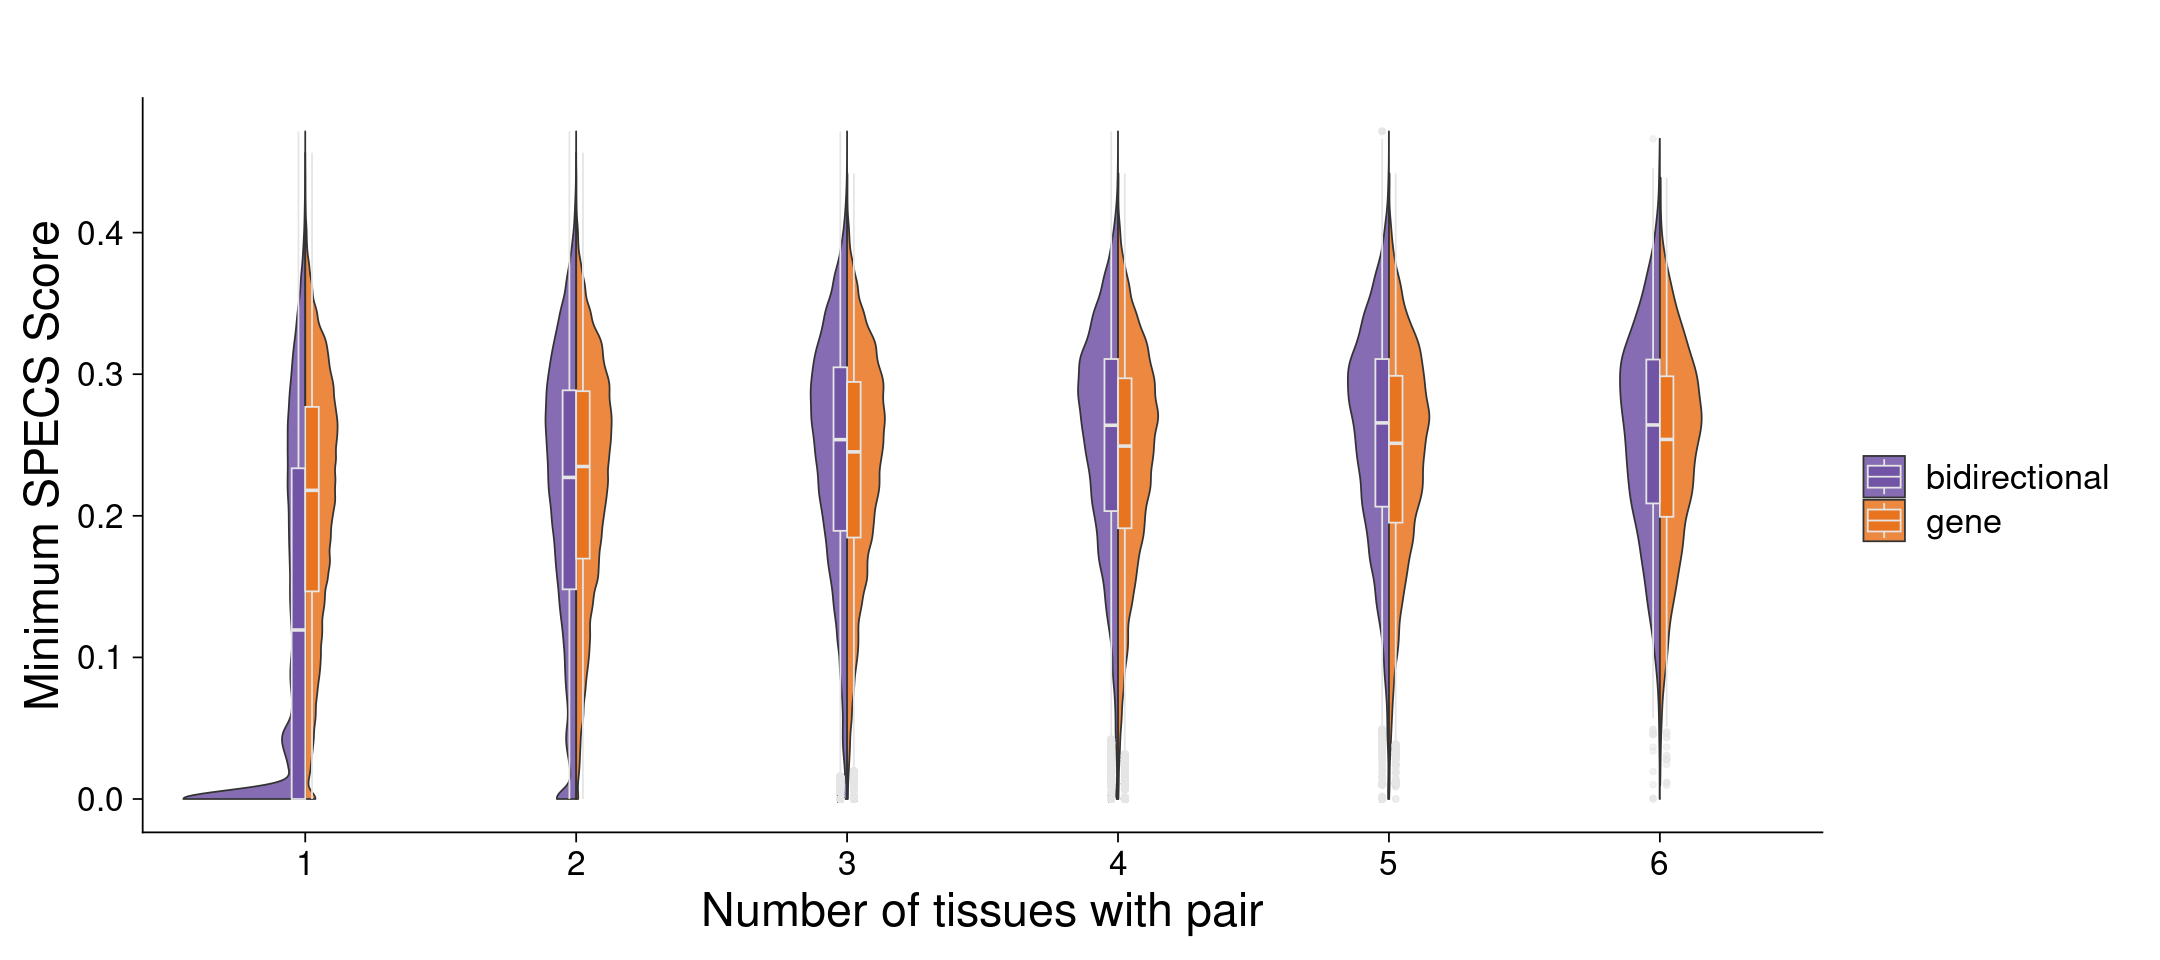

In [93]:
options(repr.plot.width=18, repr.plot.height=8)

# Use single color
gene_bidir_tissues_minspecs_boxplot_split <- ggplot(num_tissues_specs_genes_bidirs, 
                                     aes(x=Freq, y=min, 
                                        fill=transcript_type)) +
geom_split_violin(color="gray20", alpha=0.75) +
geom_boxplot(width=0.1, color="gray90", alpha=0.5, position = position_dodge(0.1)) + 
labs(title = " ", 
       y = "Minimum SPECS Score",
       x = "Number of tissues with pair",
    fill=" ") +
#scale_y_continuous(limits=c(-0.1, 1)) +
scale_fill_manual(values=c("#5e3c99","#e66101")) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 20),
      axis.text.x = element_text(size = 20)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

gene_bidir_tissues_minspecs_boxplot_split

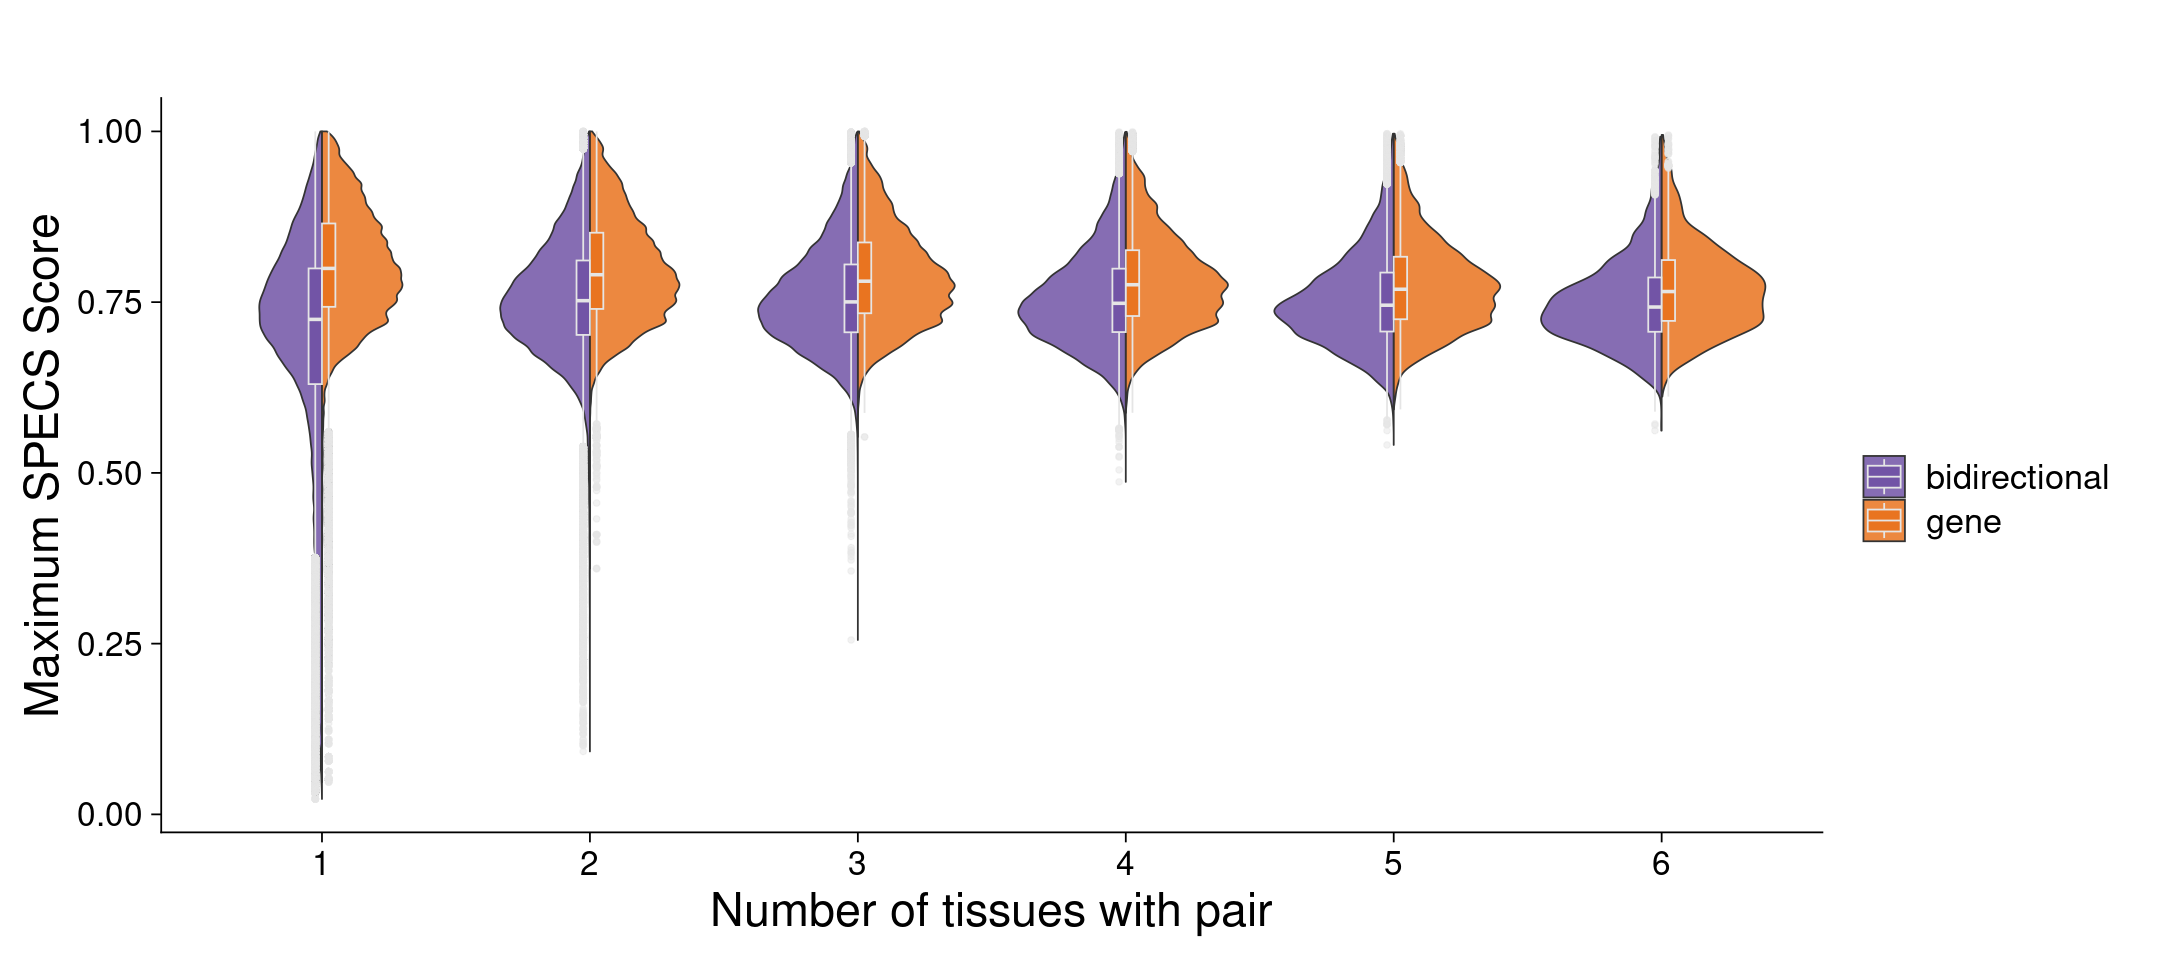

In [94]:
options(repr.plot.width=18, repr.plot.height=8)

# Use single color
gene_bidir_tissues_maxspecs_boxplot_split <- ggplot(num_tissues_specs_genes_bidirs, 
                                     aes(x=Freq, y=max, 
                                        fill=transcript_type)) +
geom_split_violin(color="gray20", alpha=0.75) +
geom_boxplot(width=0.1, color="gray90", alpha=0.5, position = position_dodge(0.1)) + 
labs(title = " ", 
       y = "Maximum SPECS Score",
       x = "Number of tissues with pair",
    fill=" ") +
#scale_y_continuous(limits=c(-0.1, 1)) +
scale_fill_manual(values=c("#5e3c99","#e66101")) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 20),
      axis.text.x = element_text(size = 20)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

gene_bidir_tissues_maxspecs_boxplot_split

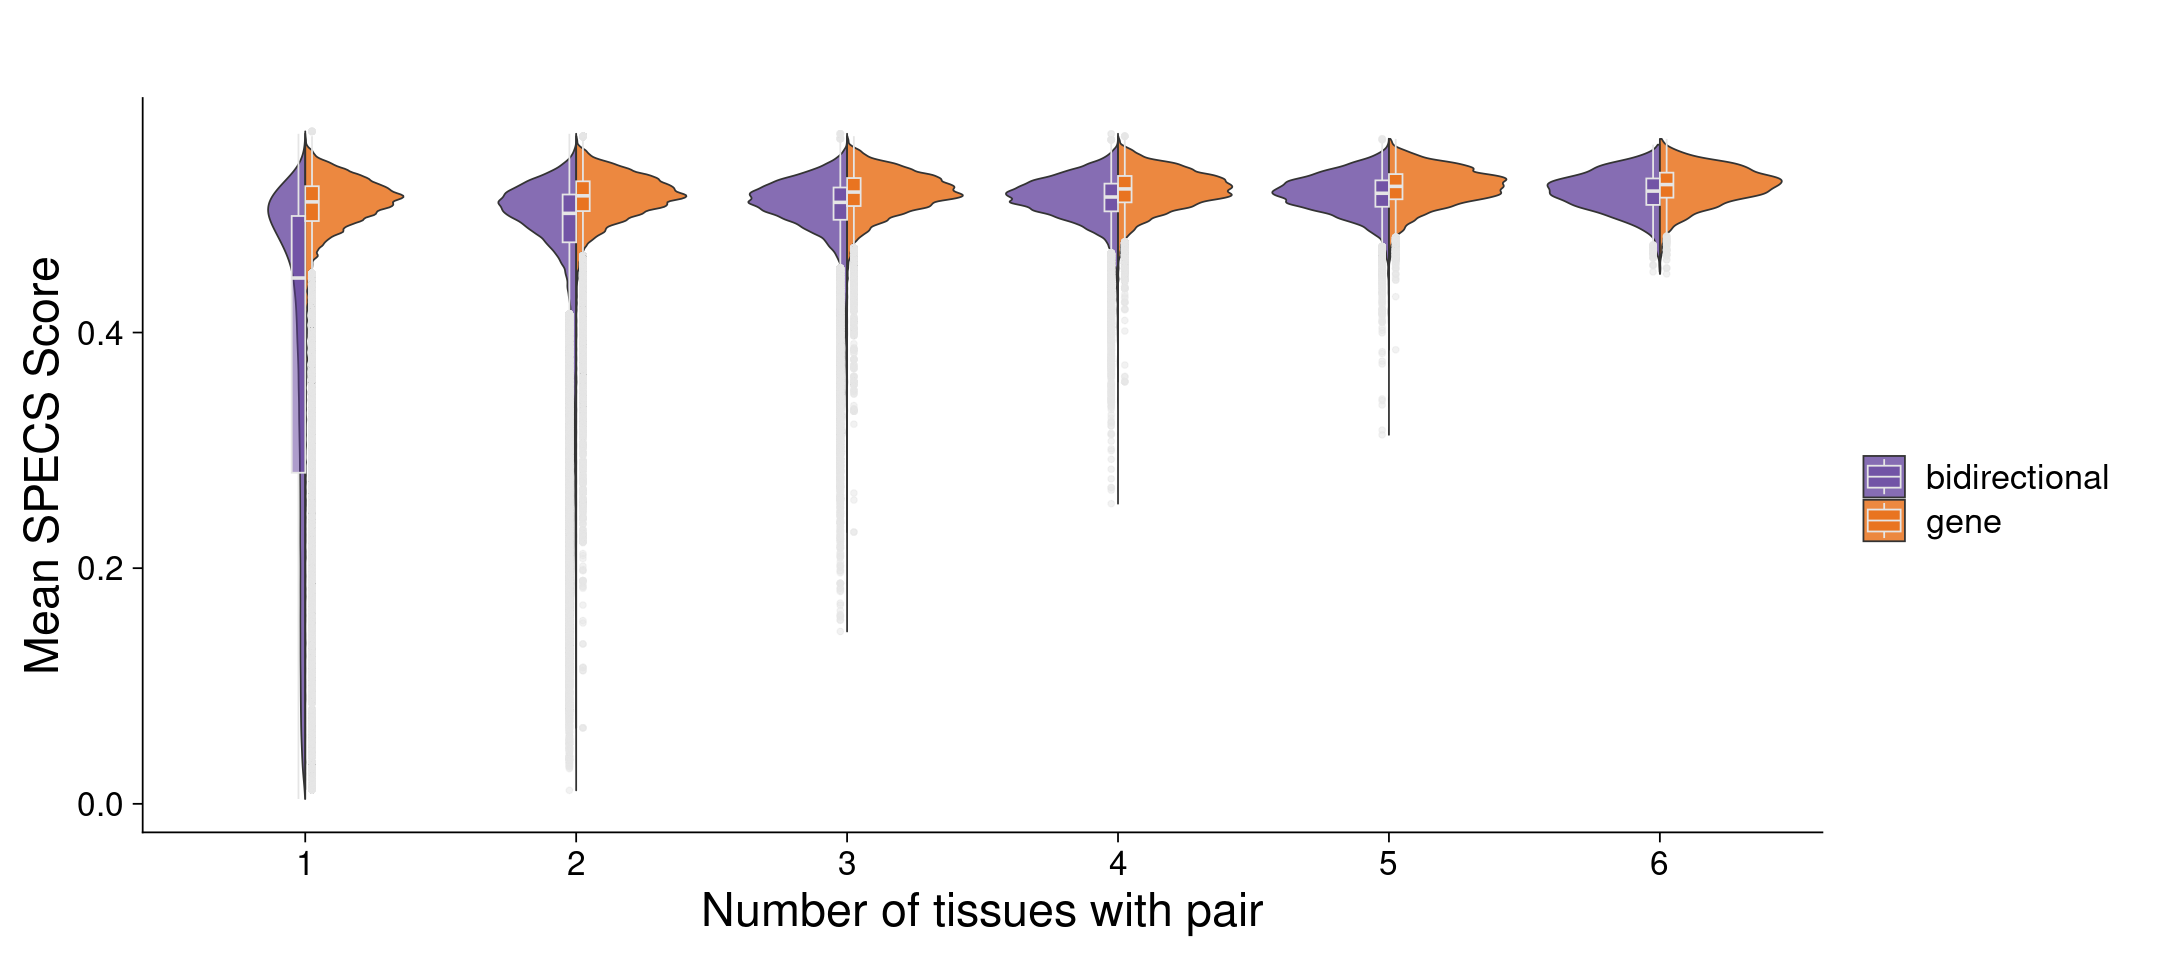

In [95]:
options(repr.plot.width=18, repr.plot.height=8)

# Use single color
gene_bidir_tissues_meanspecs_boxplot_split <- ggplot(num_tissues_specs_genes_bidirs, 
                                     aes(x=Freq, y=mean, 
                                        fill=transcript_type)) +
geom_split_violin(color="gray20", alpha=0.75) +
geom_boxplot(width=0.1, color="gray90", alpha=0.5, position = position_dodge(0.1)) + 
labs(title = " ", 
       y = "Mean SPECS Score",
       x = "Number of tissues with pair",
    fill=" ") +
#scale_y_continuous(limits=c(-0.1, 1)) +
scale_fill_manual(values=c("#5e3c99","#e66101")) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 20),
      axis.text.x = element_text(size = 20)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

gene_bidir_tissues_meanspecs_boxplot_split

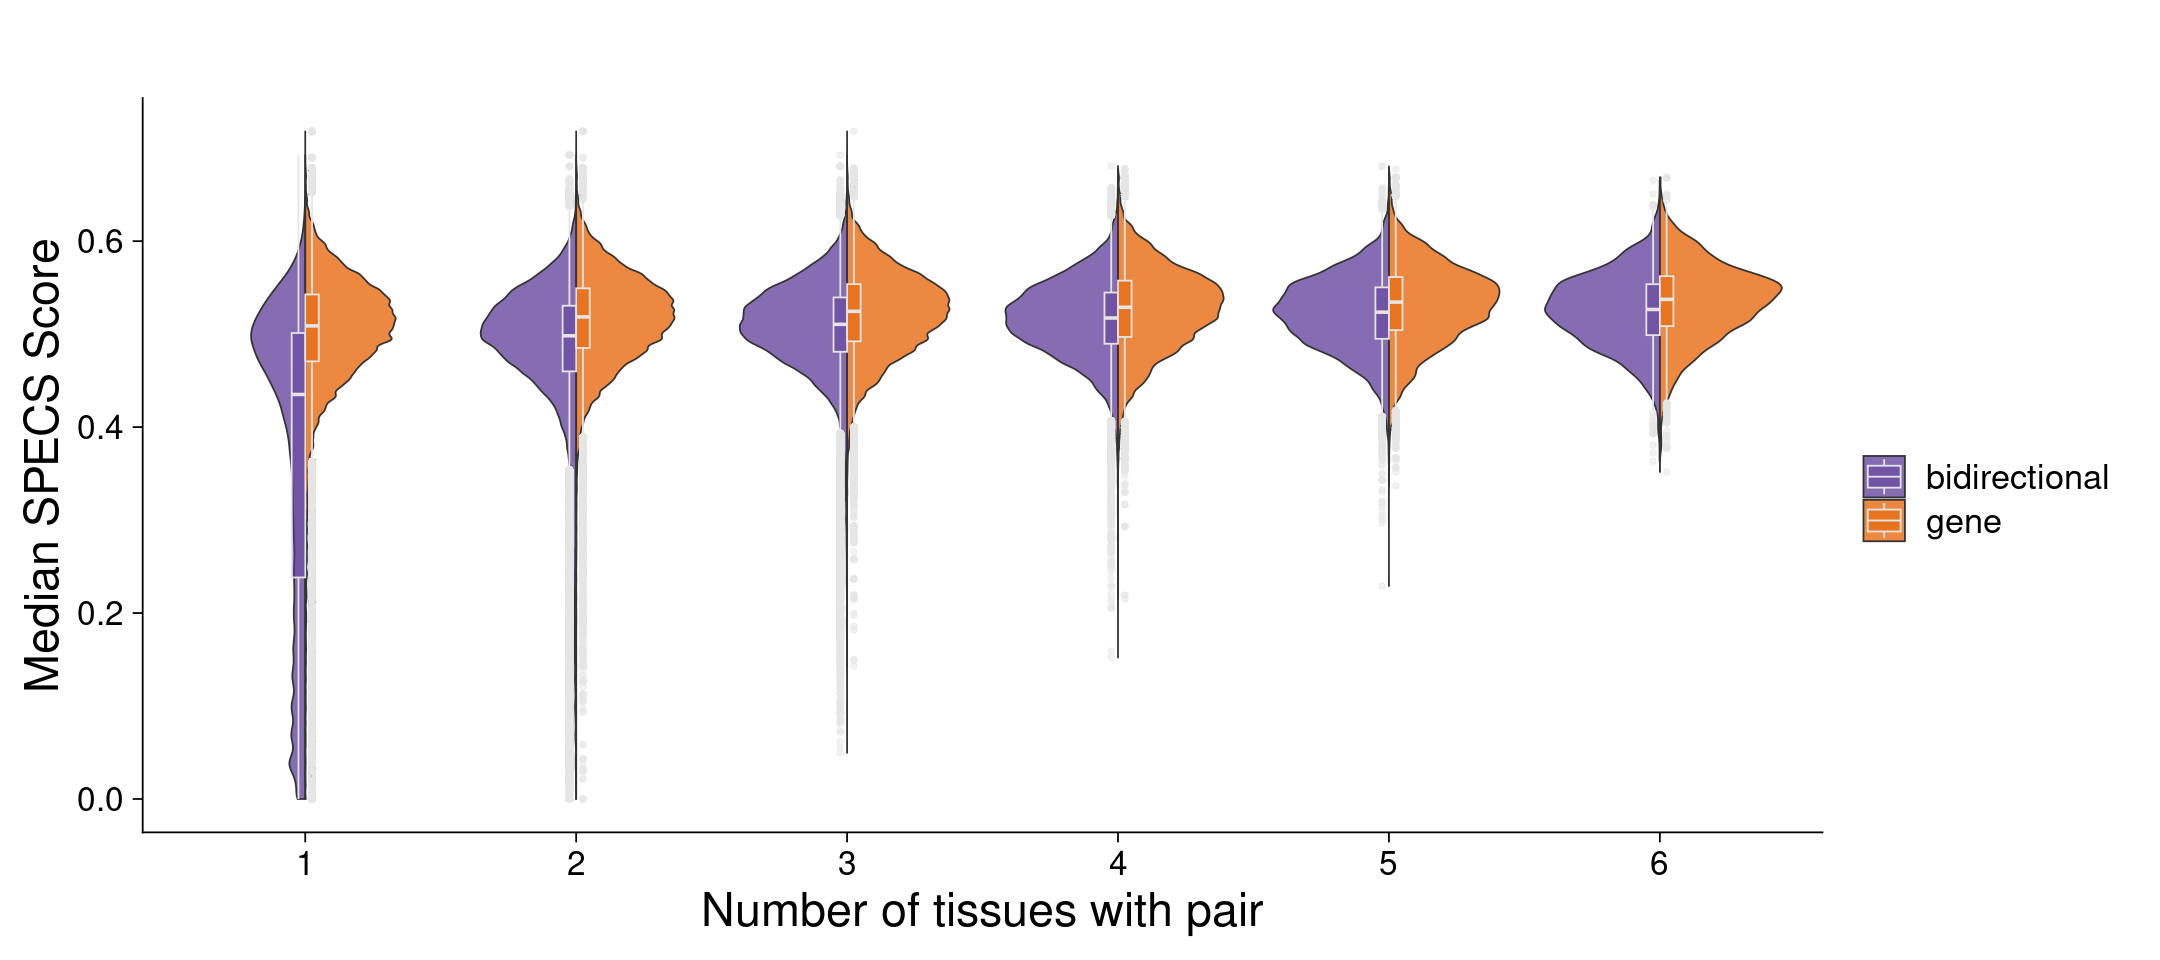

In [96]:
options(repr.plot.width=18, repr.plot.height=8)

# Use single color
gene_bidir_tissues_medspecs_boxplot_split <- ggplot(num_tissues_specs_genes_bidirs, 
                                     aes(x=Freq, y=median, 
                                        fill=transcript_type)) +
geom_split_violin(color="gray20", alpha=0.75) +
geom_boxplot(width=0.1, color="gray90", alpha=0.5, position = position_dodge(0.1)) + 
labs(title = " ", 
       y = "Median SPECS Score",
       x = "Number of tissues with pair",
    fill=" ") +
#scale_y_continuous(limits=c(-0.1, 1)) +
scale_fill_manual(values=c("#5e3c99","#e66101")) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 20),
      axis.text.x = element_text(size = 20)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

gene_bidir_tissues_medspecs_boxplot_split

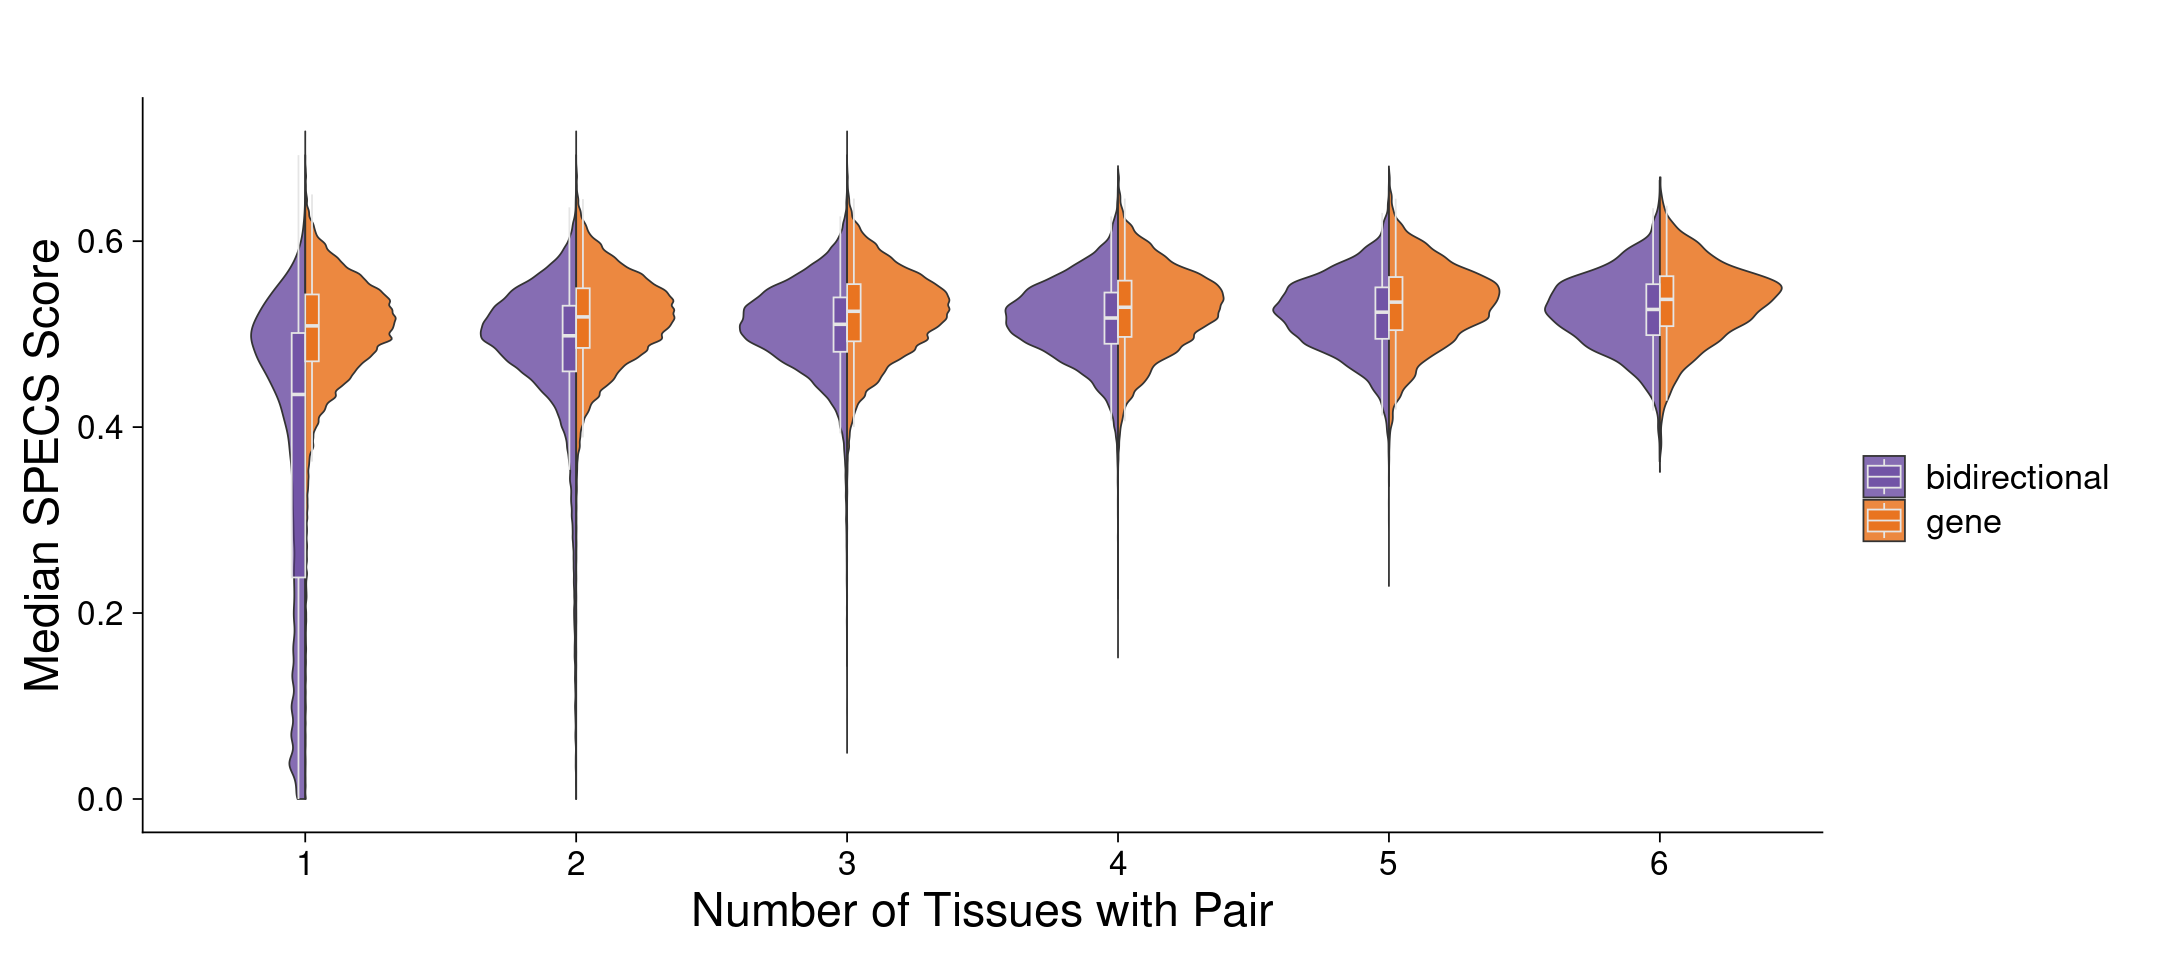

In [97]:
options(repr.plot.width=18, repr.plot.height=8)

# Use single color
gene_bidir_tissues_medspecs_boxplot_split2 <- ggplot(num_tissues_specs_genes_bidirs, 
                                     aes(x=Freq, y=median, 
                                        fill=transcript_type)) +
geom_split_violin(color="gray20", alpha=0.75) +
geom_boxplot(width=0.1,
             color="gray90", 
             alpha=0.5,
             position = position_dodge(0.1),
            outlier.shape = NA) + 
labs(title = " ", 
       y = "Median SPECS Score",
       x = "Number of Tissues with Pair",
    fill=" ") +
#scale_y_continuous(limits=c(-0.1, 1)) +
scale_fill_manual(values=c("#5e3c99","#e66101")) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 20),
      axis.text.x = element_text(size = 20)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

gene_bidir_tissues_medspecs_boxplot_split2

In [98]:
ggsave(gene_bidir_tissues_medspecs_boxplot_split2, width = 18, height = 8,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gene_bidir_tissues_median_specs_plot_reviews.pdf',
      bg = "transparent")

ggsave(gene_bidir_tissues_medspecs_boxplot_split2, width = 18, height = 8,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gene_bidir_tissues_median_specs_plot_reviews.png',
      bg = "transparent")

### Combine bins

In [99]:
num_tissues_specs_genes_bidirs$Freq_Tissues <- ifelse(as.numeric(num_tissues_specs_genes_bidirs$Freq) > 2,
                                                     ">=3",
                                                     num_tissues_specs_genes_bidirs$Freq)
num_tissues_specs_genes_bidirs$Freq_Tissues <- factor(num_tissues_specs_genes_bidirs$Freq_Tissues,
                                                     levels=c("1","2",">=3"))

In [100]:
unique(num_tissues_specs_genes_bidirs$Freq_Tissues)

[1] 1   2   >=3
Levels: 1 2 >=3

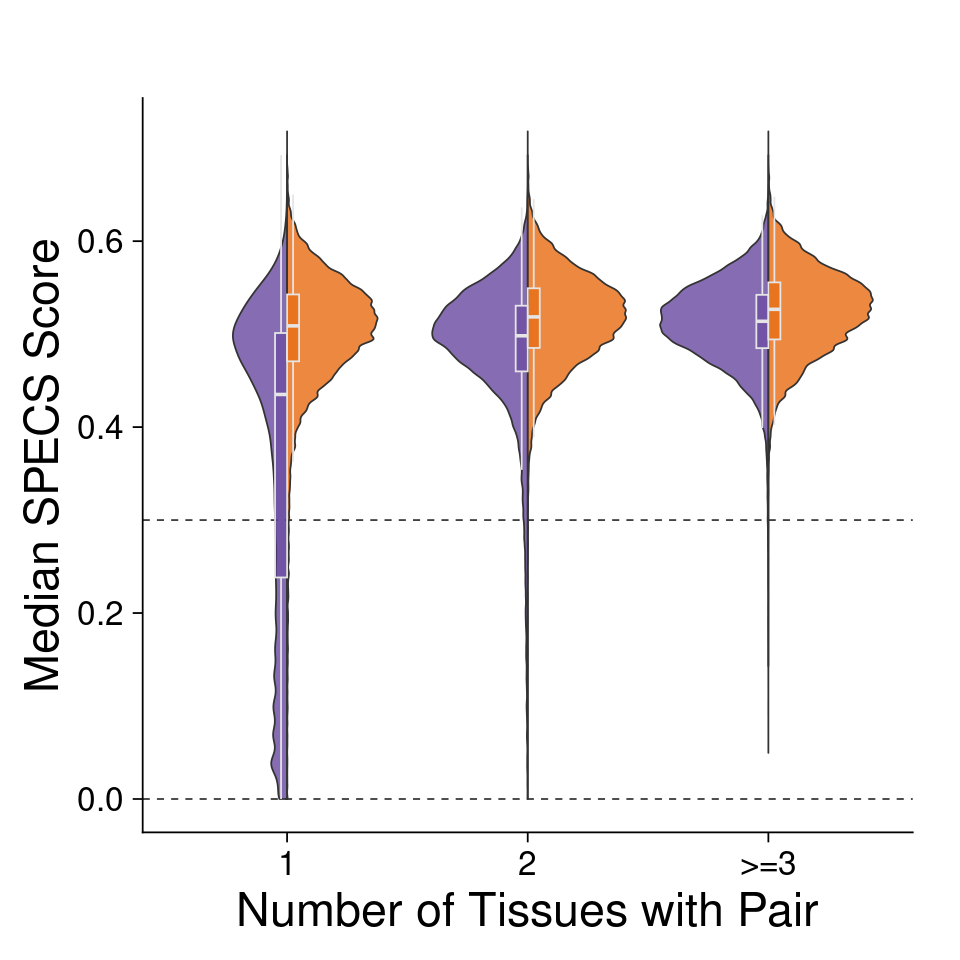

In [101]:
options(repr.plot.width=8, repr.plot.height=8)

# Use single color
gene_bidir_tissues_medspecs_boxplot_combine <- ggplot(num_tissues_specs_genes_bidirs, 
                                     aes(x=Freq_Tissues, y=median, 
                                        fill=transcript_type)) +
geom_hline(yintercept = 0.3,
           linetype="dashed", 
           color = "gray20", 
           linewidth=0.5) +
geom_hline(yintercept = 0,
           linetype="dashed", 
           color = "gray20", 
           linewidth=0.5) +
geom_split_violin(color="gray20", alpha=0.75) +
geom_boxplot(width=0.1,
             color="gray90", 
             alpha=0.5,
             position = position_dodge(0.1),
            outlier.shape = NA) + 
labs(title = " ", 
       y = "Median SPECS Score",
       x = "Number of Tissues with Pair",
    fill=" ") +
scale_fill_manual(values=c("#5e3c99","#e66101")) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 20),
      axis.text.x = element_text(size = 20),
     legend.position="none") +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

gene_bidir_tissues_medspecs_boxplot_combine

In [102]:
ggsave(gene_bidir_tissues_medspecs_boxplot_combine, width = 8, height = 8,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gene_bidir_tissues_median_specs_combine_plot_reviews.pdf',
      bg = "transparent")

ggsave(gene_bidir_tissues_medspecs_boxplot_combine, width = 8, height = 8,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gene_bidir_tissues_median_specs_combine_plot_reviews.png',
      bg = "transparent")

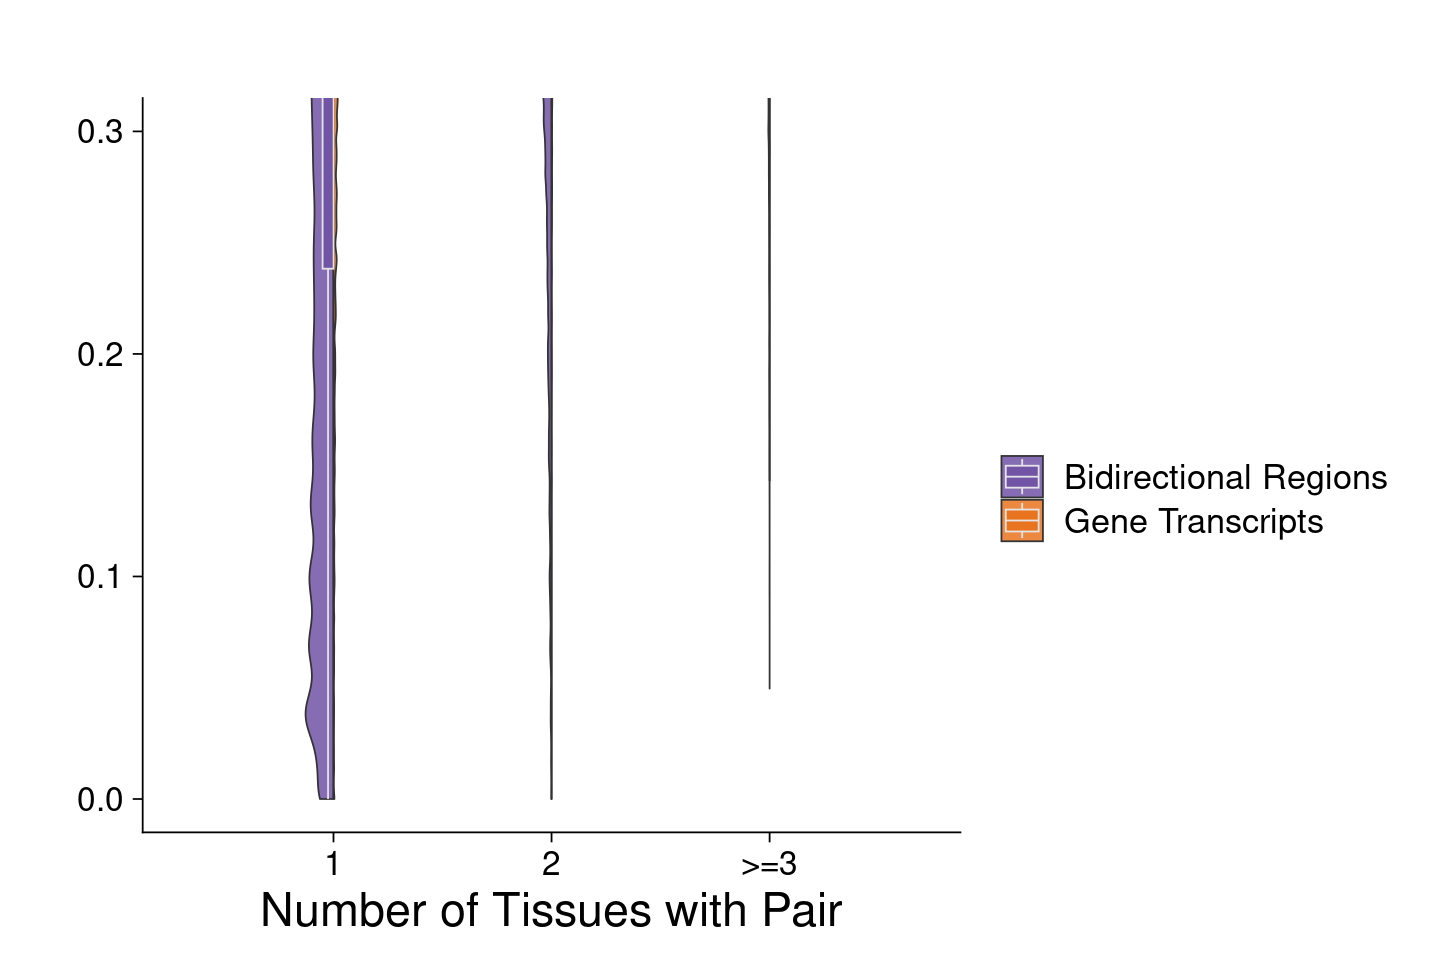

In [103]:
options(repr.plot.width=12, repr.plot.height=8)

# Use single color
gene_bidir_tissues_medspecs_boxplot_zoom <- ggplot(num_tissues_specs_genes_bidirs, 
                                     aes(x=Freq_Tissues, y=median, 
                                        fill=transcript_type)) +
geom_split_violin(color="gray20", alpha=0.75, width=1.75) +
geom_boxplot(width=0.1,
             color="gray90", 
             alpha=0.5,
             position = position_dodge(0.1),
            outlier.shape = NA) + 
labs(title = " ", 
       y = " ",
       x = "Number of Tissues with Pair",
    fill=" ") +
#scale_y_continuous(limits=c(-0.1, 0.3)) +
coord_cartesian(ylim=c(0, 0.3)) +
scale_fill_manual(values = c("#5e3c99","#e66101"),
                 labels = c("Bidirectional Regions", 
                            "Gene Transcripts")) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 20),
      axis.text.x = element_text(size = 20)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

gene_bidir_tissues_medspecs_boxplot_zoom

In [104]:
ggsave(gene_bidir_tissues_medspecs_boxplot_zoom, width = 12, height = 8,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gene_bidir_tissues_median_specs_combine_zoom_plot_reviews.pdf',
      bg = "transparent")

ggsave(gene_bidir_tissues_medspecs_boxplot_zoom, width = 12, height = 8,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gene_bidir_tissues_median_specs_combine_zoom_plot_reviews.png',
      bg = "transparent")

#  Session Information

In [105]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/libopenblasp-r0.3.3.so;  LAPACK version 3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Denver
tzcode source: system (glibc)

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] VennDiagram_1.7.3   futile.logger_1.4.3 cowplot_1.1.3      
[4] ggplot2_3.5.1       dplyr_1.1.4         data.table_1.16.2  

loaded via a namespace (and not attached):
 [1] gtable_0.3.6         jsonlite_1.8.9       compiler_4.4.0      
 [4] cray